In [1]:
import pandas
from numpy import round_
from scipy.io import arff
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
from dl85 import DL85Predictor
from dl85 import DL85Classifier
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
import MyCode.utils as utils
import graphviz
from MyCode import relabeling
from MyCode import relabeling_sklearn

In [2]:
df = pandas.read_csv("dataset_perso/Lawsuit.csv")
FILE_NAME = "lawsuit_k_supp2_relab"

del df['ID']
salary_mean = np.mean(np.array(df["Sal94"].tolist(), float))
for i in range(0,len(df)):
    if df.at[i, "Sal94"] >= salary_mean:
        df.at[i, "Salary_mean"] = 1
    else:
        df.at[i, "Salary_mean"] = 0
del df["Sal94"]
del df["Sal95"]
col = ['Rank', 'Dept']
df = df.drop(['Prate', 'Exper'], axis=1)
df = pd.get_dummies(df, columns=col)

for i in range(0,len(df)):
    if df.at[i, "Gender"] == 1:
        df.at[i, "Gender"] = 0
    else:
        df.at[i, "Gender"] = 1


X = df.loc[:, ~df.columns.isin(['Gender', 'Salary_mean'])]
y = df['Salary_mean']
sensitive = df['Gender']
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(1, X, y, sensitive)

In [3]:
pd.set_option('max_columns', None)

# src: https://www.kaggle.com/hjmjerry/gender-discrimination
df = pandas.read_csv("save/lawsuit_k_supp2.csv")
for leaf_limit in range (1, 4):
    df['discrimination_relab_'+str(leaf_limit)] = np.nan
    df['accuracy_relab_'+str(leaf_limit)] = np.nan
    df['sum_discri_'+str(leaf_limit)] = np.nan
    df['sum_discri_abs_'+str(leaf_limit)] = np.nan

for threshold in range (1, 4):
    df['discrimination_relab_'+str(threshold)] = np.nan
    df['accuracy_relab_'+str(threshold)] = np.nan
    df['sum_discri_'+str(threshold)] = np.nan
    df['sum_discri_abs_'+str(threshold)] = np.nan

In [4]:
import math
import ast
from tqdm import tqdm
def round_down(a):
    return math.floor(a * 100000)/100000.0
clf = DL85Classifier(max_depth=1, error_function=lambda tids: utils.misclassified(list(tids), y_train), min_sup=2, time_limit=600)
clf.fit(X_train)

run = False
if run:
    for leaf_limit in range (1, 4):
        for index, row in tqdm(df.iterrows(), total=df.shape[0]):
            #if (index in [1551, 1573, 1591, 1595, 1596, 1597] or index < 1900) and False:
            #    continue
            random_state = df.at[index, 'random_state']
            accuracy_train = df.at[index, 'accuracy_train']
            discrimination_train_pred = df.at[index, 'discrimination_train_pred']

            X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(random_state, X, y, sensitive)
            clf.tree_ = ast.literal_eval(df.at[index, 'clf.tree_'])
            y_pred_train = clf.predict(X_train)

            leafs_relab = relabeling.relab_leaf_limit(clf.tree_, y_train, y_pred_train, sensitive_train, leaf_limit)
            sum_acc = 0
            sum_disc = 0
            for leaf in leafs_relab:
                relabeling.browse_and_relab(clf.tree_, list(leaf.path), leaf)
                sum_acc += leaf.acc
                sum_disc += leaf.disc
            y_pred_train_relab = clf.predict(X_train)
            discrimation_train_pred_relab = round_down(relabeling.discrimination(y_train, y_pred_train_relab, sensitive_train))
            df.at[index, 'discrimination_relab_'+str(leaf_limit)] = discrimation_train_pred_relab
            accuracy_train_relab = round_down(accuracy_score(y_train, y_pred_train_relab))
            df.at[index, 'accuracy_relab_'+str(leaf_limit)] = accuracy_train_relab

            utils.tree_upgrade(clf.tree_, y_train, y_pred_train_relab, sensitive_train)
            sum_discri_ = round_down(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_pred', do_abs=False))
            sum_discri_abs_ = round_down(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_pred', do_abs=True))
            df.at[index, 'sum_discri_'+str(leaf_limit)] = sum_discri_
            df.at[index, 'sum_discri_abs_'+str(leaf_limit)] = sum_discri_abs_

            new_acc= round_down(accuracy_train+sum_acc)
            new_disc = round_down(discrimination_train_pred+sum_disc)
            if not (round_down(new_acc) == round_down(accuracy_train_relab) or round_down(new_disc)== round_down(discrimation_train_pred_relab)):
                print(index)
                print(df.iloc[index])
                print(f"{relabeling.discrimination(y_train, y_pred_train_relab, sensitive_train)}")
                print()

                for leaf in leafs_relab:
                    print(leaf)
                print(f"Accuracy:\n"
                      f"    Before      : {accuracy_train}\n"
                      f"    Leafs       : {sum_acc}\n"
                      f"    After       : {accuracy_train_relab}\n"
                      f"    Before+Leafs: {new_acc}\n"
                      f"    Check       : {round_down(new_acc) == round_down(accuracy_train_relab)}\n"
                      f"    Real diff   : {accuracy_train - accuracy_train_relab}")
                print(f"Discrim:\n"
                      f"    Before      : {discrimination_train_pred}\n"
                      f"    Leafs       : {sum_disc }\n"
                      f"    After       : {discrimation_train_pred_relab}\n"
                      f"    Before+Leafs: {new_disc}\n"
                      f"    Check       : {round_down(new_disc)== round_down(discrimation_train_pred_relab)}\n"
                      f"    Real diff   : {discrimination_train_pred - discrimation_train_pred_relab}")
                display(graphviz.Source(utils.export_graphviz(clf)))

                assert(round_down(new_acc) == round_down(accuracy_train_relab))
                assert(round_down(new_disc)== round_down(discrimation_train_pred_relab))
        df.to_csv('save/'+FILE_NAME+'.csv', index=False)
    display(df.iloc[1000])

In [5]:
if run:
    for threshold in [0.0, 0.1, 0.2, 0.3]:
        for index, row in tqdm(df.iterrows(), total=df.shape[0]):

            random_state = df.at[index, 'random_state']
            accuracy_train = df.at[index, 'accuracy_train']
            discrimination_train_pred = df.at[index, 'discrimination_train_pred']

            X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(random_state, X, y, sensitive)
            clf.tree_ = ast.literal_eval(df.at[index, 'clf.tree_'])
            y_pred_train = clf.predict(X_train)

            leafs_relab = relabeling.relab(clf.tree_, y_train, y_pred_train, sensitive_train, threshold)
            sum_acc = 0
            sum_disc = 0
            for leaf in leafs_relab:
                relabeling.browse_and_relab(clf.tree_, list(leaf.path), leaf)
                sum_acc += leaf.acc
                sum_disc += leaf.disc
            y_pred_train_relab = clf.predict(X_train)
            discrimation_train_pred_relab = round_down(relabeling.discrimination(y_train, y_pred_train_relab, sensitive_train))
            df.at[index, 'discrimination_relab_'+str(threshold)] = discrimation_train_pred_relab
            accuracy_train_relab = round_down(accuracy_score(y_train, y_pred_train_relab))
            df.at[index, 'accuracy_relab_'+str(threshold)] = accuracy_train_relab

            utils.tree_upgrade(clf.tree_, y_train, y_pred_train_relab, sensitive_train)
            sum_discri_ = round_down(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_pred', do_abs=False))
            sum_discri_abs_ = round_down(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_pred', do_abs=True))
            df.at[index, 'sum_discri_'+str(threshold)] = sum_discri_
            df.at[index, 'sum_discri_abs_'+str(threshold)] = sum_discri_abs_

            new_acc= round_down(accuracy_train+sum_acc)
            new_disc = round_down(discrimination_train_pred+sum_disc)
            if not ( discrimation_train_pred_relab <= threshold or round_down(new_acc) == round_down(accuracy_train_relab) or round_down(new_disc)== round_down(discrimation_train_pred_relab)):
                print(index)
                print(df.iloc[index])
                print(f"{discrimation_train_pred_relab}")
                print()

                for leaf in leafs_relab:
                    print(leaf)
                print(f"Accuracy:\n"
                      f"    Before      : {accuracy_train}\n"
                      f"    Leafs       : {sum_acc}\n"
                      f"    After       : {accuracy_train_relab}\n"
                      f"    Before+Leafs: {new_acc}\n"
                      f"    Check       : {round_down(new_acc) == round_down(accuracy_train_relab)}\n"
                      f"    Real diff   : {accuracy_train - accuracy_train_relab}")
                print(f"Discrim:\n"
                      f"    Before      : {discrimination_train_pred}\n"
                      f"    Leafs       : {sum_disc }\n"
                      f"    After       : {discrimation_train_pred_relab}\n"
                      f"    Before+Leafs: {new_disc}\n"
                      f"    Check       : {round_down(new_disc)== round_down(discrimation_train_pred_relab)}\n"
                      f"    Real diff   : {discrimination_train_pred - discrimation_train_pred_relab}")
                display(graphviz.Source(utils.export_graphviz(clf)))
                assert(relabeling.discrimination(y_train, y_pred_train_relab, sensitive_train) <= threshold)
                assert(round_down(new_acc) == round_down(accuracy_train_relab))
                assert(round_down(new_disc)== round_down(discrimation_train_pred_relab))

        df.to_csv('save/'+FILE_NAME+'.csv', index=False)

In [6]:
df = pandas.read_csv('save/'+FILE_NAME+'.csv')
df

,k,depth,random_state,clf.error_,clf.accuracy_,accuracy_train,accuracy_test,sum_misclassified_train,sum_discrimination_additive_pred_abs,sum_discrimination_additive_train_abs,sum_discrimination_additive_train,sum_discrimination_additive_train_pred,discrimination_train,discrimination_train_pred,discrimination_test,duration,min_supp,clf.tree_,discrimination_relab_1,accuracy_relab_1,sum_discri_1,sum_discri_abs_1,discrimination_relab_2,accuracy_relab_2,sum_discri_2,sum_discri_abs_2,discrimination_relab_3,accuracy_relab_3,sum_discri_3,sum_discri_abs_3,discrimination_relab_0.0,accuracy_relab_0.0,sum_discri_0.0,sum_discri_abs_0.0,discrimination_relab_0.1,accuracy_relab_0.1,sum_discri_0.1,sum_discri_abs_0.1,discrimination_relab_0.2,accuracy_relab_0.2,sum_discri_0.2,sum_discri_abs_0.2,discrimination_relab_0.3,accuracy_relab_0.3,sum_discri_0.3,sum_discri_abs_0.3
0,0,1,1,51.000000,0.755981,0.755981,0.730769,51,0.156476,0.325619,0.325619,0.156476,0.325619,0.156476,0.266667,0.034566,2,"{'feat': 10, 'left': {'value': 1, 'error': 0.0...",0.00000,0.60287,0.000000,0.000000,-0.15648,0.24401,-0.156476,0.156476,-0.15648,0.24401,-0.156476,0.156476,0.00000,0.60287,0.000000,0.000000,0.00000,0.60287,0.000000,0.000000,0.15647,0.75598,0.156476,0.156476,0.15647,0.75598,0.156476,0.156476
1,1,1,1,51.325619,0.754423,0.755981,0.730769,51,0.156476,0.325619,0.325619,0.156476,0.325619,0.156476,0.266667,0.033039,2,"{'feat': 10, 'left': {'value': 1, 'error': 0.1...",0.00000,0.60287,0.000000,0.000000,-0.15648,0.24401,-0.156476,0.156476,-0.15648,0.24401,-0.156476,0.156476,0.00000,0.60287,0.000000,0.000000,0.00000,0.60287,0.000000,0.000000,0.15647,0.75598,0.156476,0.156476,0.15647,0.75598,0.156476,0.156476
2,5,1,1,52.628094,0.748191,0.755981,0.730769,51,0.156476,0.325619,0.325619,0.156476,0.325619,0.156476,0.266667,0.037227,2,"{'feat': 10, 'left': {'value': 1, 'error': 0.7...",0.00000,0.60287,0.000000,0.000000,-0.15648,0.24401,-0.156476,0.156476,-0.15648,0.24401,-0.156476,0.156476,0.00000,0.60287,0.000000,0.000000,0.00000,0.60287,0.000000,0.000000,0.15647,0.75598,0.156476,0.156476,0.15647,0.75598,0.156476,0.156476
3,10,1,1,54.256191,0.740401,0.755981,0.730769,51,0.156476,0.325619,0.325619,0.156476,0.325619,0.156476,0.266667,0.040053,2,"{'feat': 10, 'left': {'value': 1, 'error': 1.5...",0.00000,0.60287,0.000000,0.000000,-0.15648,0.24401,-0.156476,0.156476,-0.15648,0.24401,-0.156476,0.156476,0.00000,0.60287,0.000000,0.000000,0.00000,0.60287,0.000000,0.000000,0.15647,0.75598,0.156476,0.156476,0.15647,0.75598,0.156476,0.156476
4,50,1,1,67.280952,0.678082,0.755981,0.730769,51,0.156476,0.325619,0.325619,0.156476,0.325619,0.156476,0.266667,0.036994,2,"{'feat': 10, 'left': {'value': 1, 'error': 7.8...",0.00000,0.60287,0.000000,0.000000,-0.15648,0.24401,-0.156476,0.156476,-0.15648,0.24401,-0.156476,0.156476,0.00000,0.60287,0.000000,0.000000,0.00000,0.60287,0.000000,0.000000,0.15647,0.75598,0.156476,0.156476,0.15647,0.75598,0.156476,0.156476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3460,250,7,99,107.093262,0.487592,0.918660,0.826923,17,0.286508,0.360373,0.360373,0.286508,0.360373,0.286508,0.063796,2.511431,2,"{'feat': 5, 'left': {'feat': 0, 'left': {'feat...",0.26351,0.90909,0.263520,0.309497,0.17156,0.87081,0.171566,0.401451,0.14697,0.85645,0.146976,0.376861,-0.03194,0.69856,-0.031939,0.372244,0.08620,0.81339,0.086207,0.372056,0.17156,0.87081,0.171566,0.401451,0.28650,0.91866,0.286508,0.286508
3461,500,7,99,197.186523,0.056524,0.918660,0.826923,17,0.286508,0.360373,0.360373,0.286508,0.360373,0.286508,0.063796,2.331966,2,"{'feat': 5, 'left': {'feat': 0, 'left': {'feat...",0.26351,0.90909,0.263520,0.309497,0.17156,0.87081,0.171566,0.401451,0.14697,0.85645,0.146976,0.376861,-0.03194,0.69856,-0.031939,0.372244,0.08620,0.81339,0.086207,0.372056,0.17156,0.87081,0.171566,0.401451,0.28650,0.91866,0.286508,0.286508
3462,1000,7,99,377.3730

In [7]:
_COLORS11 = ['#8b4513', '#006400', '#4682b4', '#4b0082', '#ff0000', '#00ff7f', '#00ffff', '#0000ff', '#ffff54',
             '#ff1493', '#ffe4c4']
_COLORS4 = ['#ff0000', '#00ff00', '#0000ff', '#87cefa']
_COLORS5 = ['#008080', '#ffa500', '#00ff00', '#0000ff', '#ff1493']
_COLORS7 = ['#2e8b57', '#ff0000', '#ffd700', '#c71585', '#00ff00', '#0000ff', '#1e90ff']
_COLORS10 = ['#006400', '#00008b', '#b03060', '#ff4500', '#ffd700', '#7cfc00', '#00ffff', '#ff00ff', '#6495ed',
          '#ffdab9']

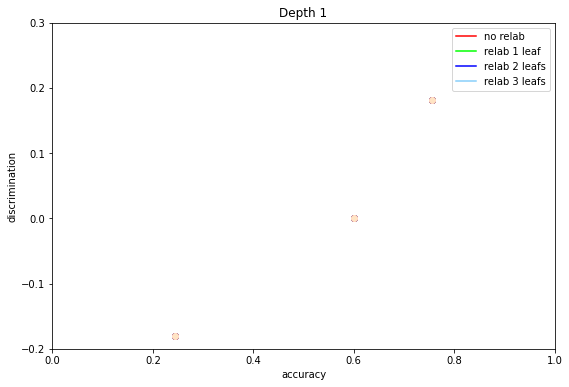

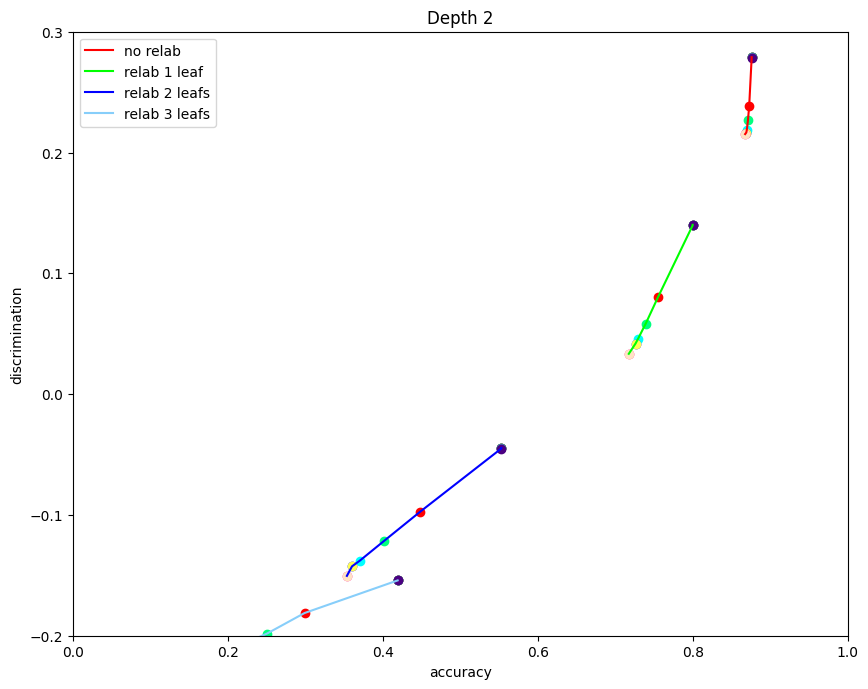

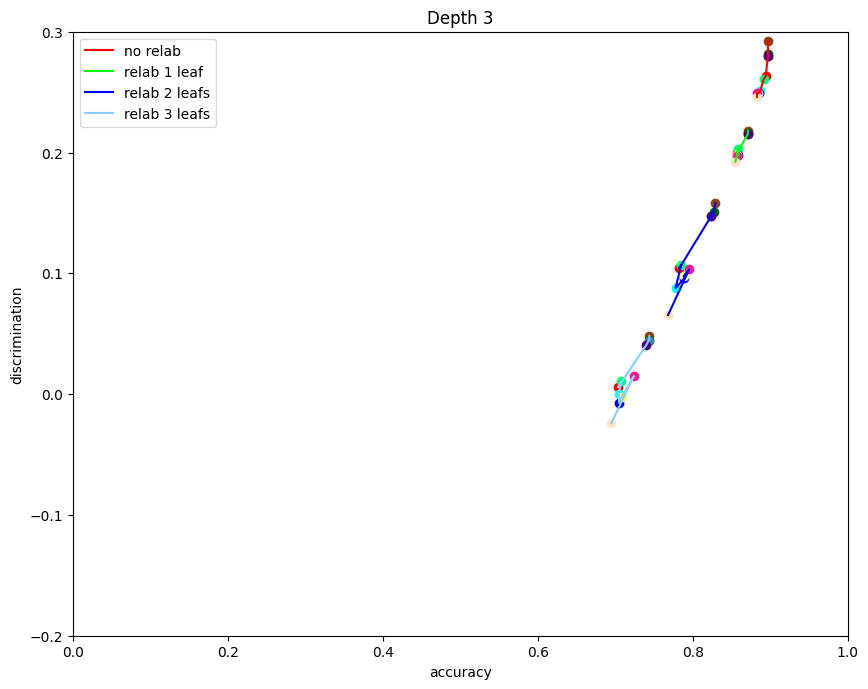

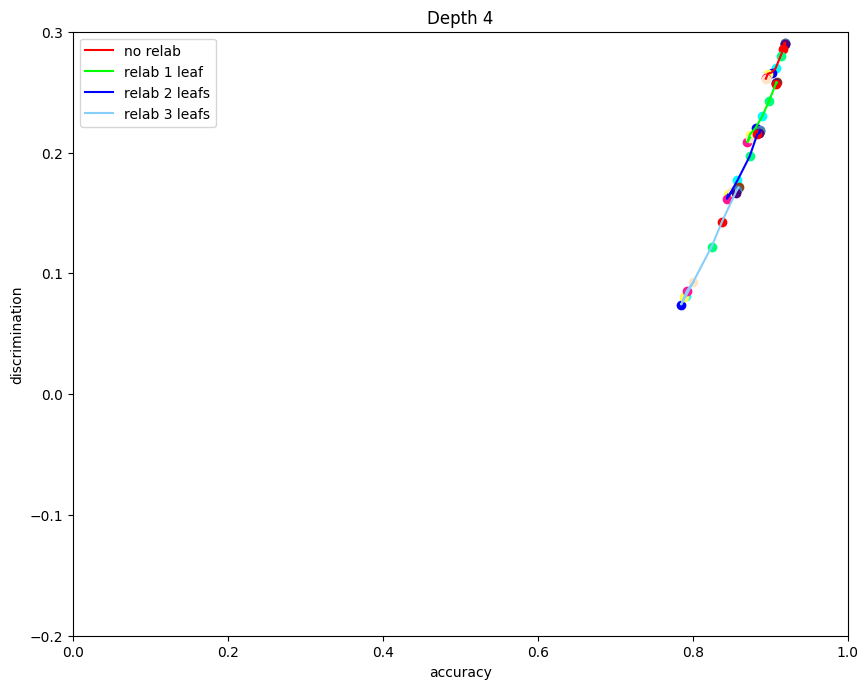

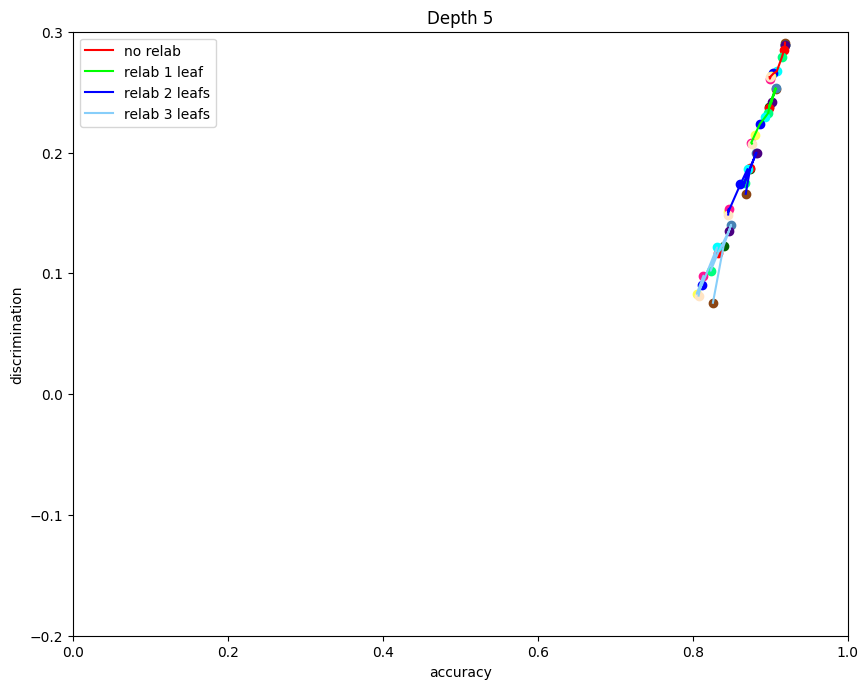

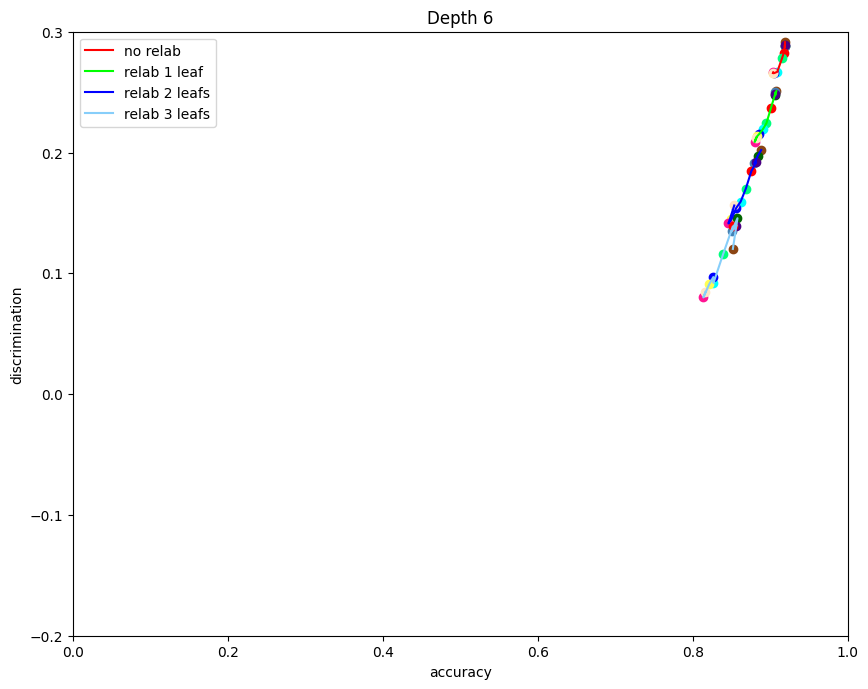

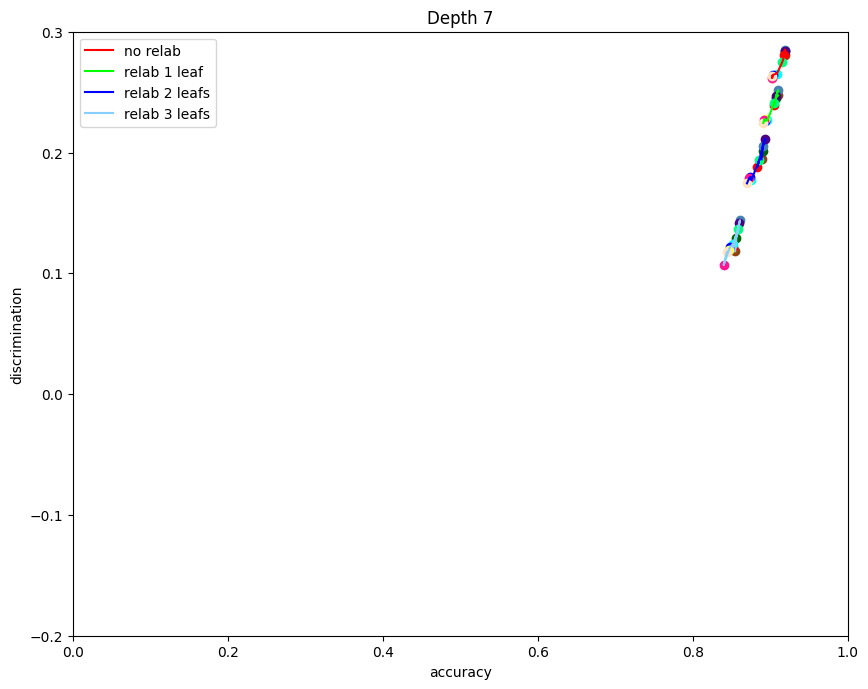

In [8]:
legends = ['no relab', 'relab 1 leaf', 'relab 2 leafs', 'relab 3 leafs']
fig, axes = plt.subplots()
colors11 = _COLORS11.copy()
colors4 = _COLORS4.copy()
for depth in df['depth'].unique():
    index_legends = 0
    for x_axe, y_axe in [('accuracy_train', 'discrimination_train_pred'), ('accuracy_relab_1', 'discrimination_relab_1'), ('accuracy_relab_2', 'discrimination_relab_2'), ('accuracy_relab_3', 'discrimination_relab_3')]:
        index_color = 0
        y_values = list()
        x_values = list()
        for k in df['k'].unique():
            tmp = df.loc[(df["k"] == k) & (df["depth"] == depth)]
            x_values.append(tmp[x_axe].mean())
            y_values.append(tmp[y_axe].mean())

            plt.scatter(tmp[x_axe].mean(), tmp[y_axe].mean(), c=colors11[index_color])
            """
            plt.annotate(k, # this is the text
                         (tmp[x_axe].mean(), tmp[y_axe].mean()), # these are the coordinates to position the label
                         textcoords="offset points", # how to position the text
                         xytext=(0,10), # distance from text to points (x,y)
                         ha='center')
            """
            index_color +=1

        plt.plot(x_values, y_values, label=legends[index_legends], c=colors4[index_legends])
        index_legends +=1
    plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
    plt.title(f'Depth {depth}')
    plt.ylabel('discrimination')
    plt.xlabel('accuracy')
    plt.ylim(-0.2, 0.3)
    plt.xlim(0, 1)
    plt.legend()

    plt.show()

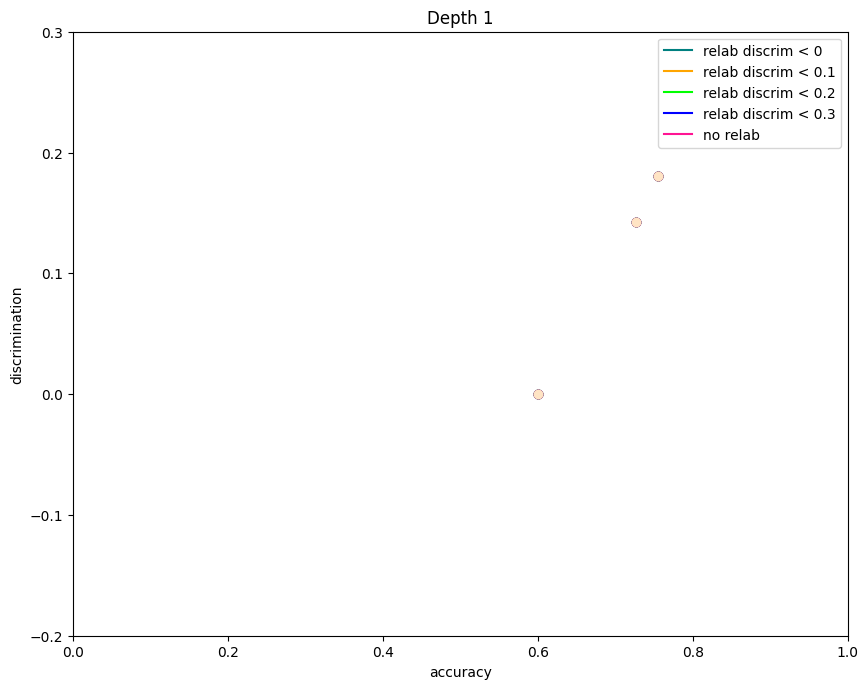

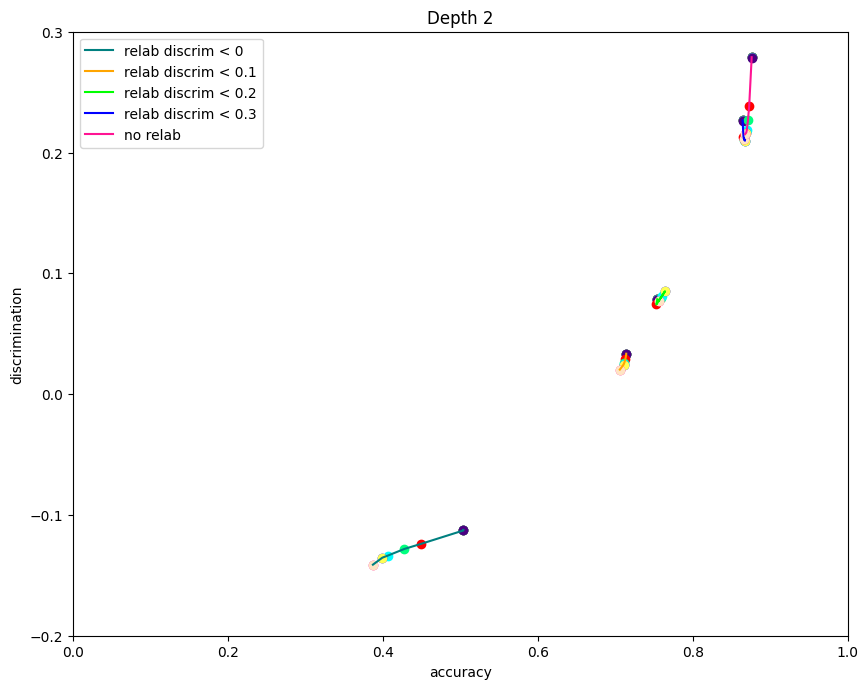

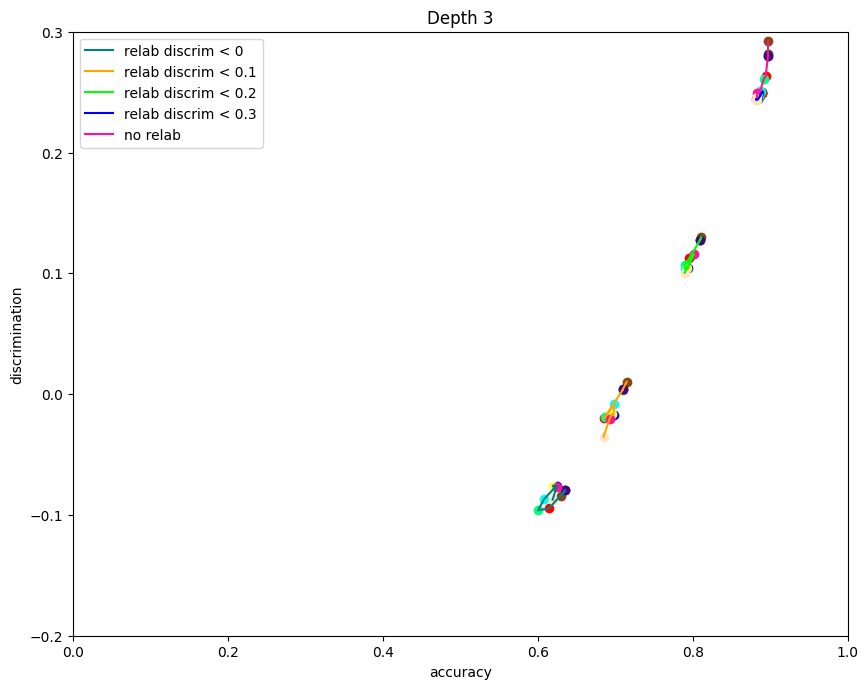

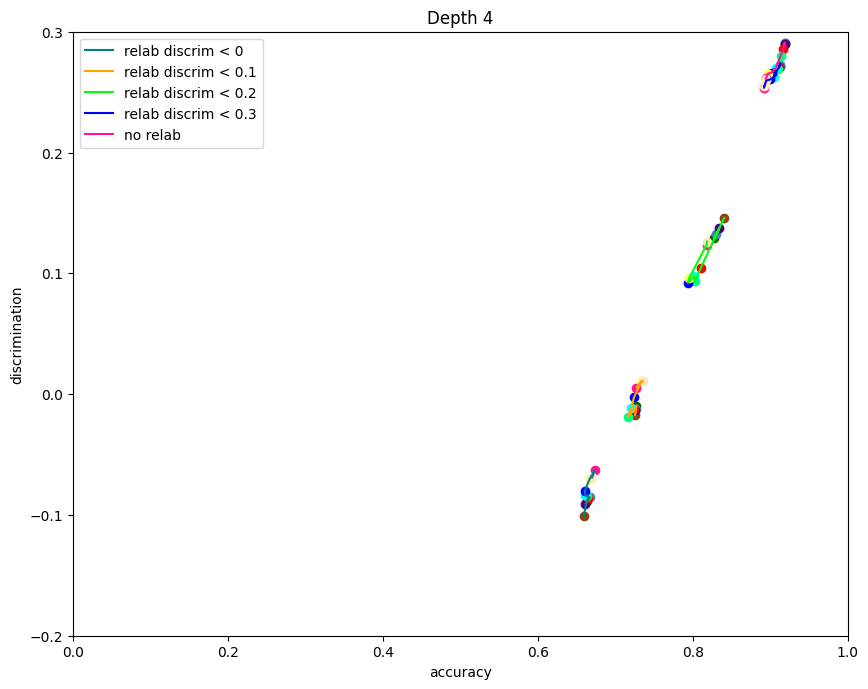

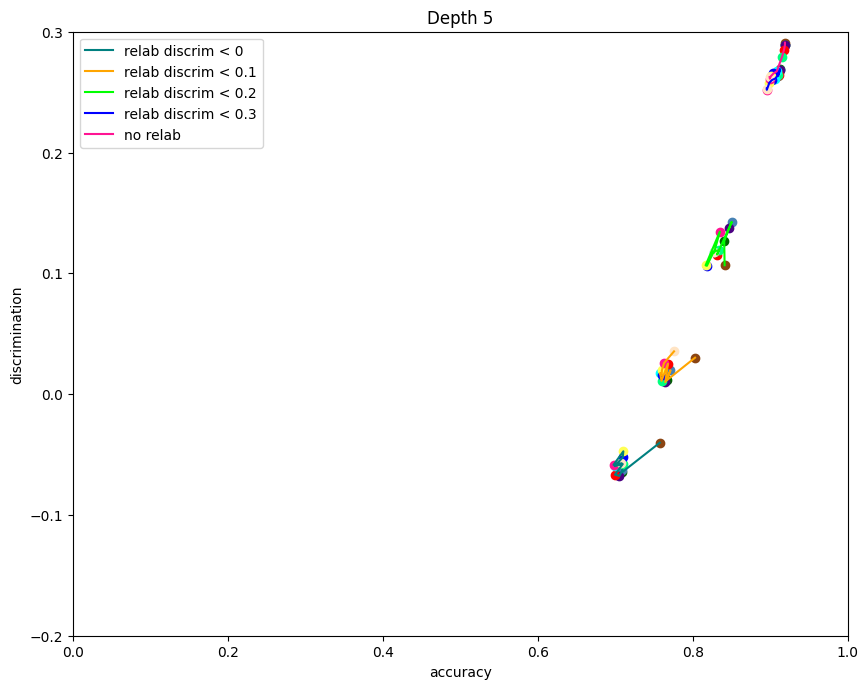

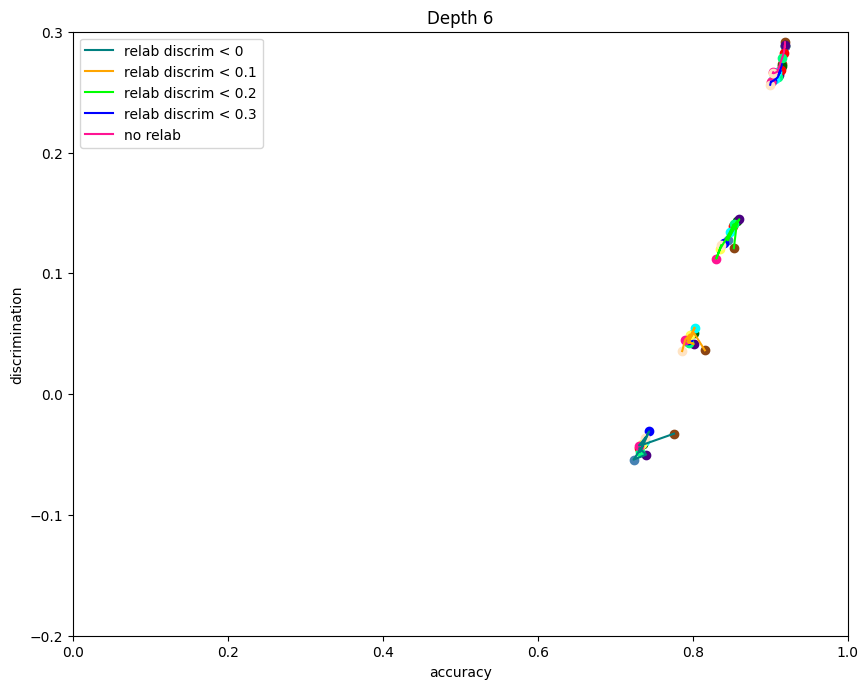

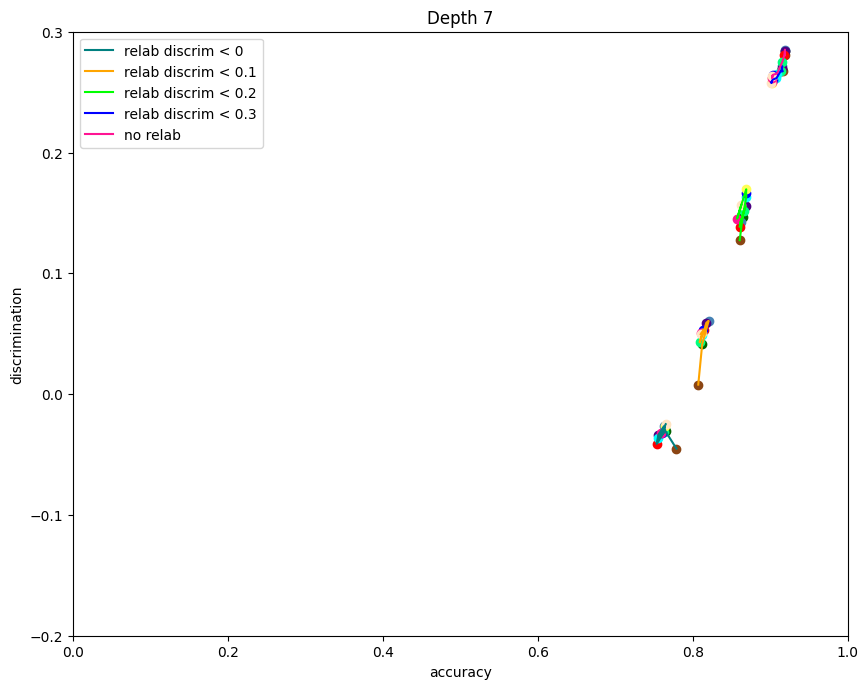

In [9]:
colors11 = _COLORS11.copy()
colors4 = _COLORS5.copy()
legends = ['relab discrim < 0', 'relab discrim < 0.1', 'relab discrim < 0.2', 'relab discrim < 0.3', 'no relab']
fig, axes = plt.subplots()
for depth in df['depth'].unique():
    index_legends = 0
    for x_axe, y_axe in [('accuracy_relab_0.0', 'discrimination_relab_0.0'), ('accuracy_relab_0.1', 'discrimination_relab_0.1'), ('accuracy_relab_0.2', 'discrimination_relab_0.2'), ('accuracy_relab_0.3', 'discrimination_relab_0.3'), ('accuracy_train', 'discrimination_train_pred')]:
        index_color = 0
        y_values = list()
        x_values = list()
        for k in df['k'].unique():
            tmp = df.loc[(df["k"] == k) & (df["depth"] == depth)]
            x_values.append(tmp[x_axe].mean())
            y_values.append(tmp[y_axe].mean())

            plt.scatter(tmp[x_axe].mean(), tmp[y_axe].mean(), c=colors11[index_color])
            """
            plt.annotate(k, # this is the text
                         (tmp[x_axe].mean(), tmp[y_axe].mean()), # these are the coordinates to position the label
                         textcoords="offset points", # how to position the text
                         xytext=(0,10), # distance from text to points (x,y)
                         ha='center')
            """
            index_color +=1

        plt.plot(x_values, y_values, label=legends[index_legends], c=colors4[index_legends])
        index_legends +=1
    plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
    plt.title(f'Depth {depth}')
    plt.ylabel('discrimination')
    plt.xlabel('accuracy')
    plt.ylim(-0.2, 0.3)
    plt.xlim(0, 1)
    plt.legend()

    plt.show()

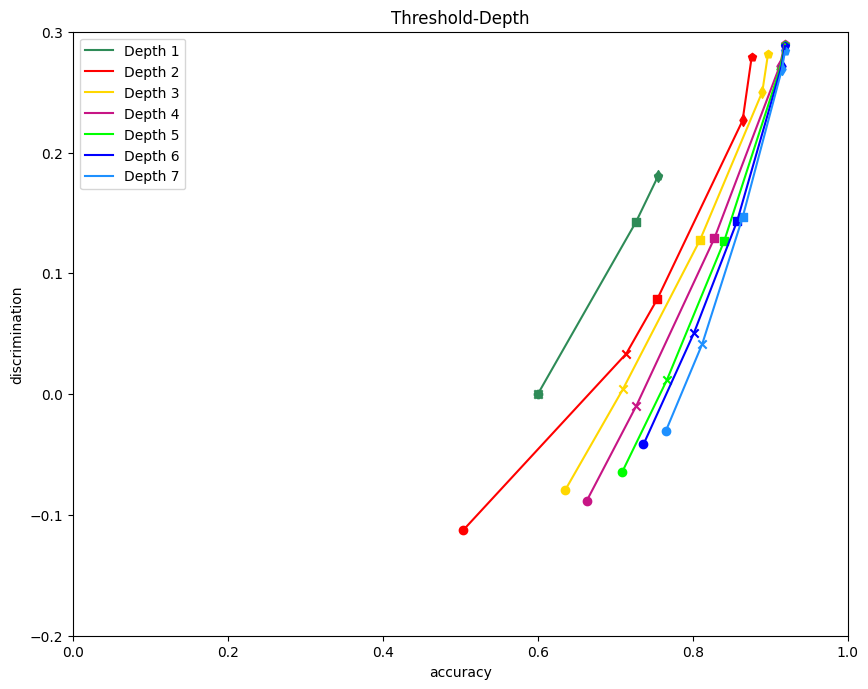

In [10]:
colors = _COLORS7.copy()
legends = ['Depth 1', 'Depth 2', 'Depth 3', 'Depth 4', 'Depth 5', 'Depth 6', 'Depth 7']
markers = ['o', 'x', 's', 'd', 'p', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']

index_legend = 0
index_color = 0


fig, axes = plt.subplots()
k=1
for depth in df['depth'].unique():
    y_values = list()
    x_values = list()
    index_marker = 0
    for x_axe, y_axe in [('accuracy_relab_0.0', 'discrimination_relab_0.0'), ('accuracy_relab_0.1', 'discrimination_relab_0.1'), ('accuracy_relab_0.2', 'discrimination_relab_0.2'), ('accuracy_relab_0.3', 'discrimination_relab_0.3'), ('accuracy_train', 'discrimination_train_pred')]:

        tmp = df.loc[(df["k"] == k) & (df["depth"] == depth)]
        x_values.append(tmp[x_axe].mean())
        y_values.append(tmp[y_axe].mean())

        plt.scatter(tmp[x_axe].mean(), tmp[y_axe].mean(), c=colors[index_color], marker=markers[index_marker])
        index_marker +=1

    plt.plot(x_values, y_values, label=legends[index_legend], c=colors[index_color])
    index_color +=1
    index_legend +=1

plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.title(f'Threshold-Depth')
plt.ylabel('discrimination')
plt.xlabel('accuracy')
plt.ylim(-0.2, 0.3)
plt.xlim(0, 1)
plt.legend()

plt.show()

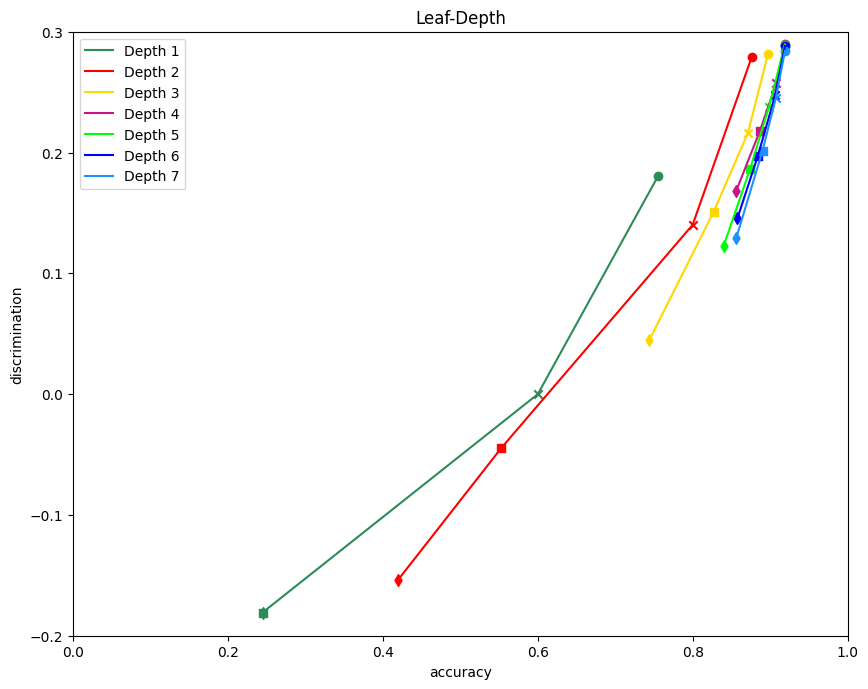

In [11]:
colors = _COLORS7.copy()
legends = ['Depth 1', 'Depth 2', 'Depth 3', 'Depth 4', 'Depth 5', 'Depth 6', 'Depth 7']
markers = ['o', 'x', 's', 'd', 'p', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']

index_legend = 0
index_color = 0


fig, axes = plt.subplots()
k=1
for depth in df['depth'].unique():
    y_values = list()
    x_values = list()
    index_marker = 0
    for x_axe, y_axe in [('accuracy_train', 'discrimination_train_pred'), ('accuracy_relab_1', 'discrimination_relab_1'), ('accuracy_relab_2', 'discrimination_relab_2'), ('accuracy_relab_3', 'discrimination_relab_3')]:

        tmp = df.loc[(df["k"] == k) & (df["depth"] == depth)]
        x_values.append(tmp[x_axe].mean())
        y_values.append(tmp[y_axe].mean())

        plt.scatter(tmp[x_axe].mean(), tmp[y_axe].mean(), c=colors[index_color], marker=markers[index_marker])
        index_marker +=1

    plt.plot(x_values, y_values, label=legends[index_legend], c=colors[index_color])
    index_color +=1
    index_legend +=1

plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.title(f'Leaf-Depth')
plt.ylabel('discrimination')
plt.xlabel('accuracy')
plt.ylim(-0.2, 0.3)
plt.xlim(0, 1)
plt.legend()

plt.show()

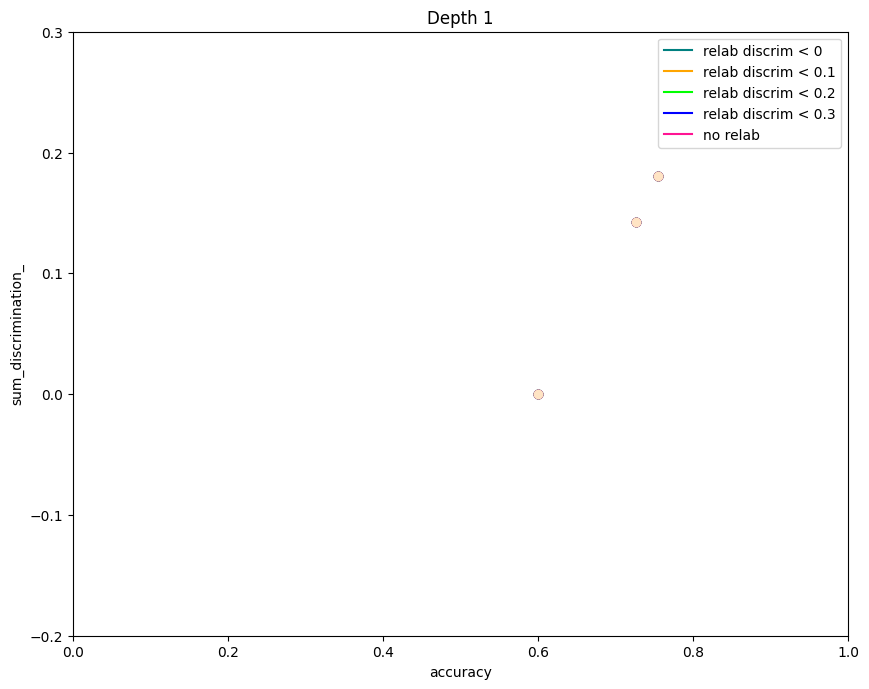

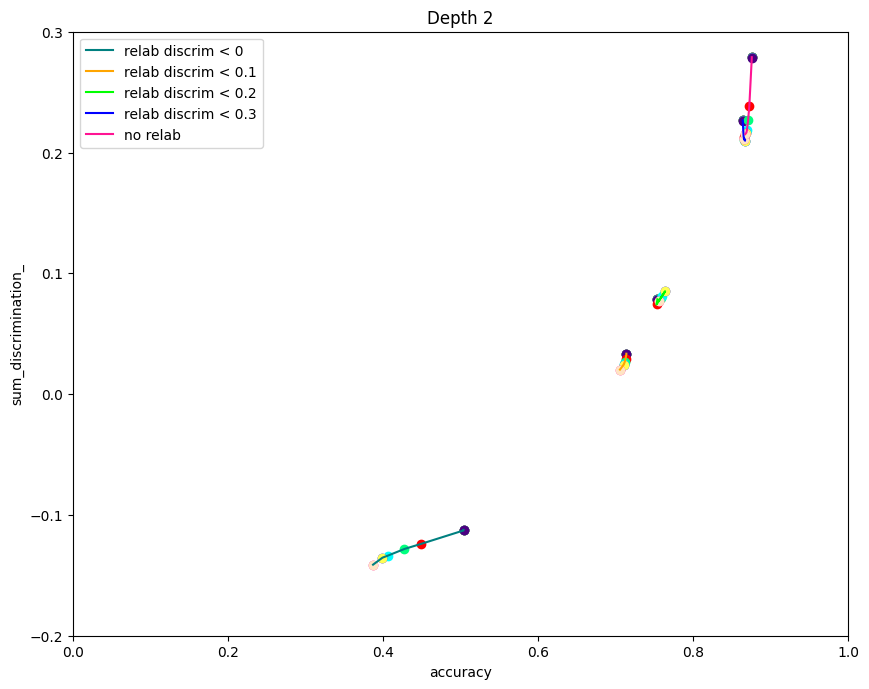

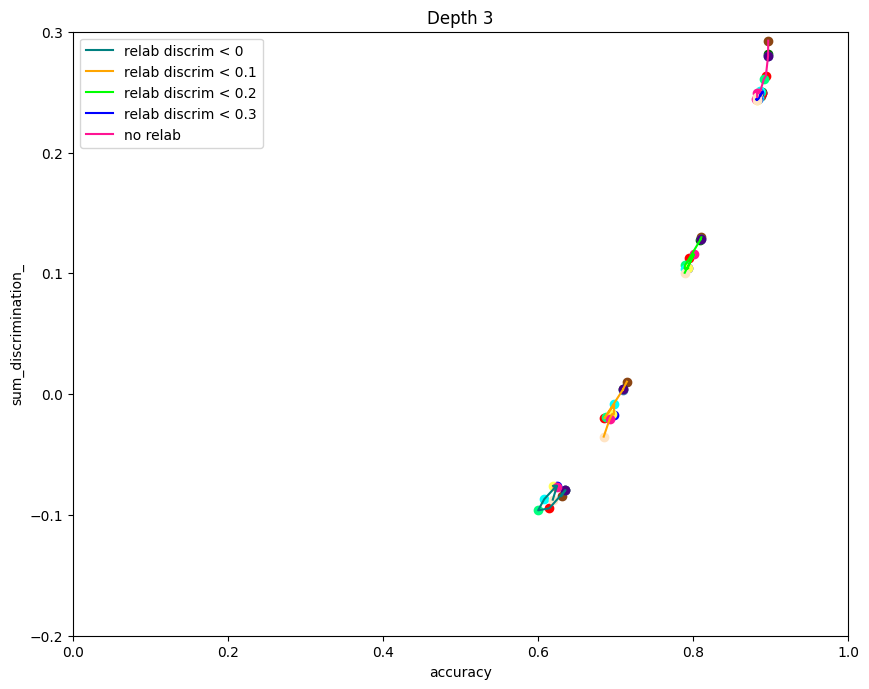

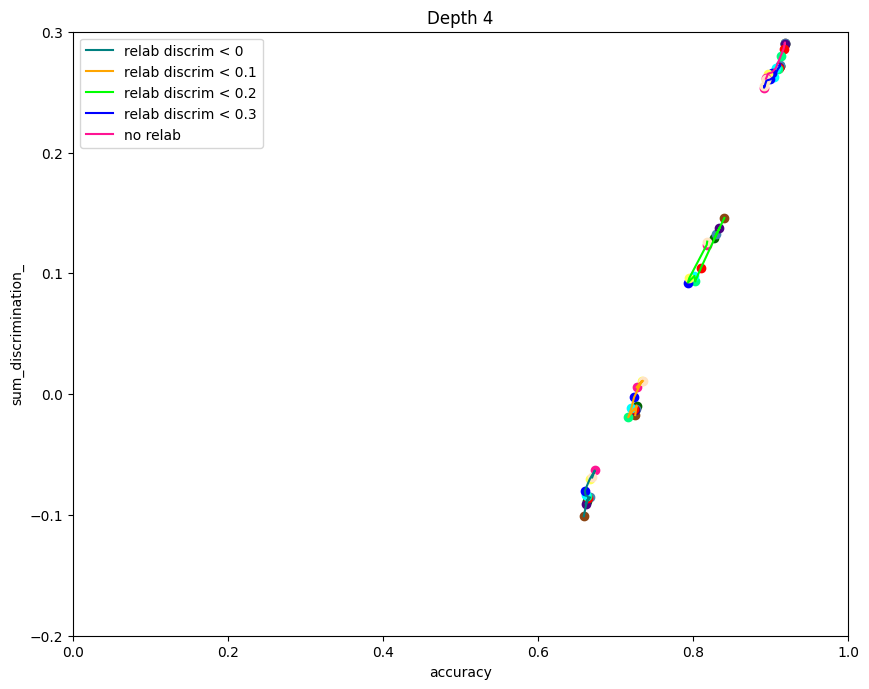

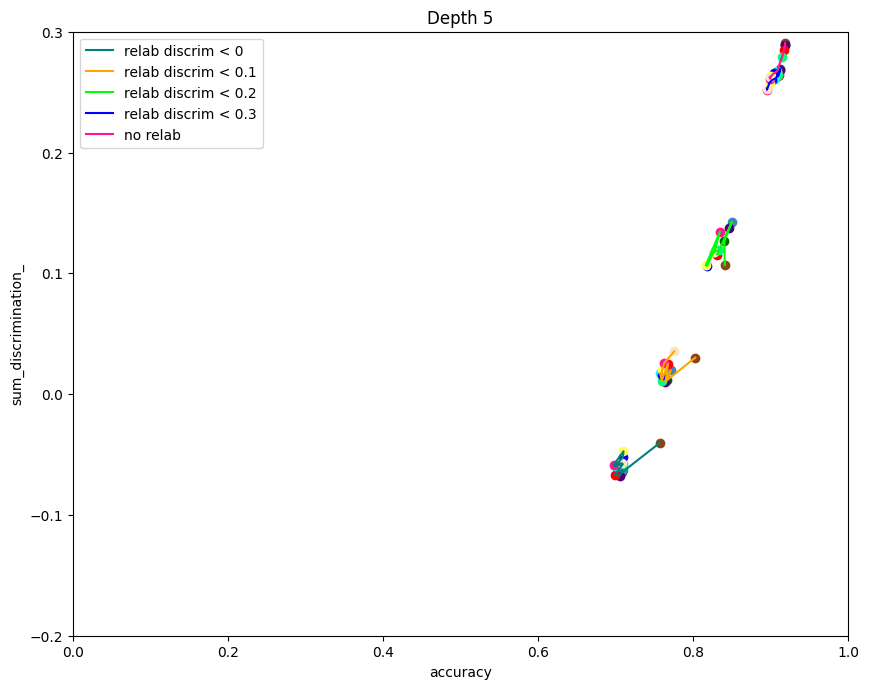

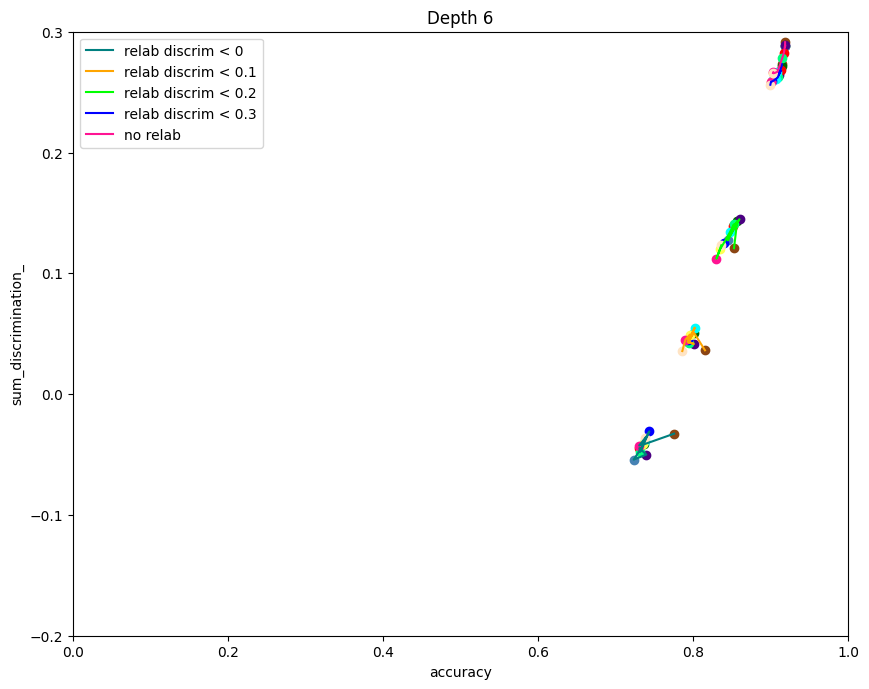

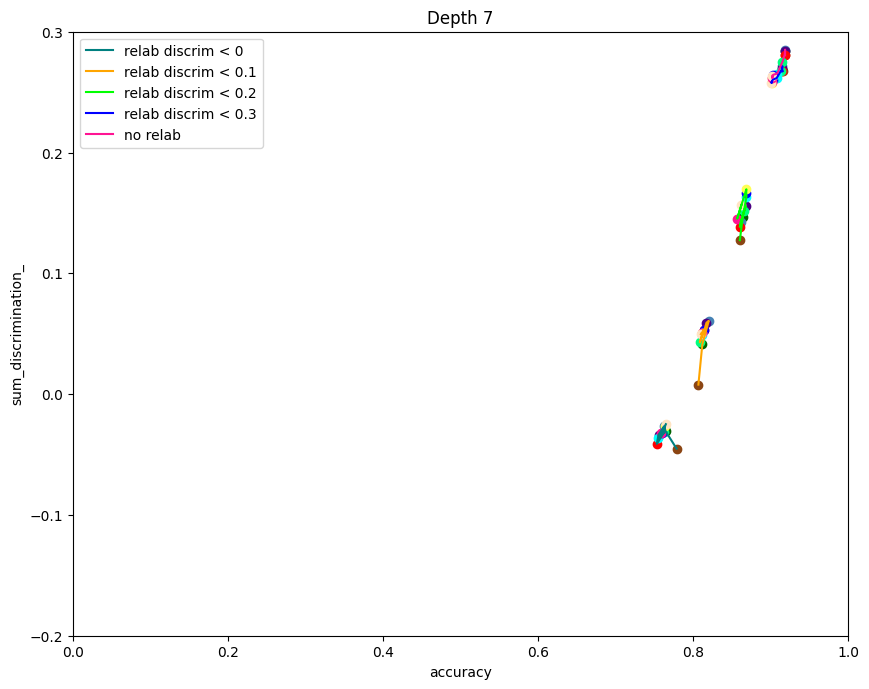

In [12]:
colors11 = _COLORS11.copy()
colors4 = _COLORS5.copy()
legends = ['relab discrim < 0', 'relab discrim < 0.1', 'relab discrim < 0.2', 'relab discrim < 0.3', 'no relab']
fig, axes = plt.subplots()
for depth in df['depth'].unique():
    index_legends = 0
    for x_axe, y_axe in [('accuracy_relab_0.0', 'sum_discri_0.0'), ('accuracy_relab_0.1', 'sum_discri_0.1'), ('accuracy_relab_0.2', 'sum_discri_0.2'), ('accuracy_relab_0.3', 'sum_discri_0.3'), ('accuracy_train', 'sum_discrimination_additive_train_pred')]:
        index_color = 0
        y_values = list()
        x_values = list()
        for k in df['k'].unique():
            tmp = df.loc[(df["k"] == k) & (df["depth"] == depth)]
            x_values.append(tmp[x_axe].mean())
            y_values.append(tmp[y_axe].mean())

            plt.scatter(tmp[x_axe].mean(), tmp[y_axe].mean(), c=colors11[index_color])
            """
            plt.annotate(k, # this is the text
                         (tmp[x_axe].mean(), tmp[y_axe].mean()), # these are the coordinates to position the label
                         textcoords="offset points", # how to position the text
                         xytext=(0,10), # distance from text to points (x,y)
                         ha='center')
            """
            index_color +=1

        plt.plot(x_values, y_values, label=legends[index_legends], c=colors4[index_legends])
        index_legends +=1
    plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
    plt.title(f'Depth {depth}')
    plt.ylabel('sum_discrimination_')
    plt.xlabel('accuracy')
    plt.ylim(-0.2, 0.3)
    plt.xlim(0, 1)
    plt.legend()

    plt.show()

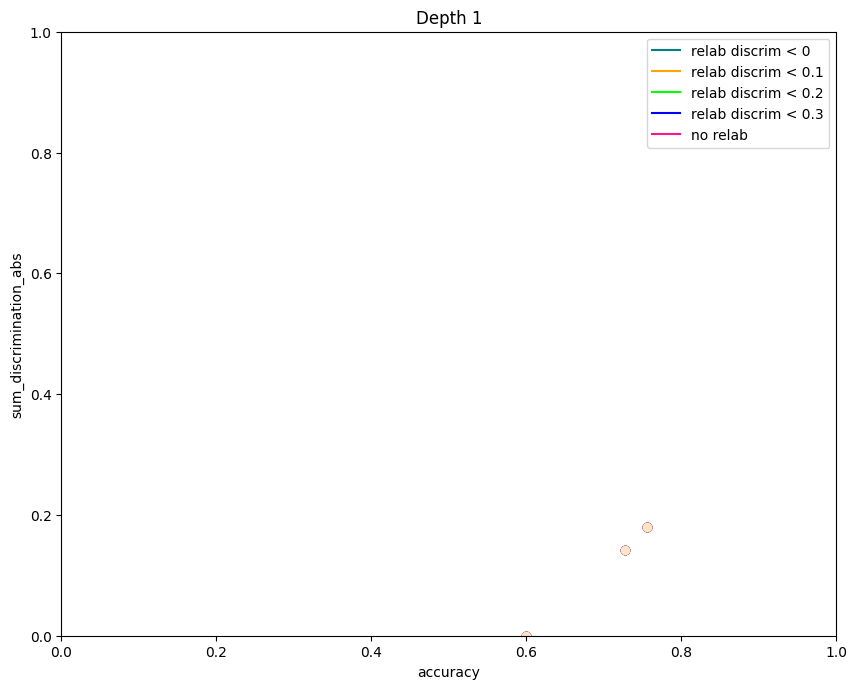

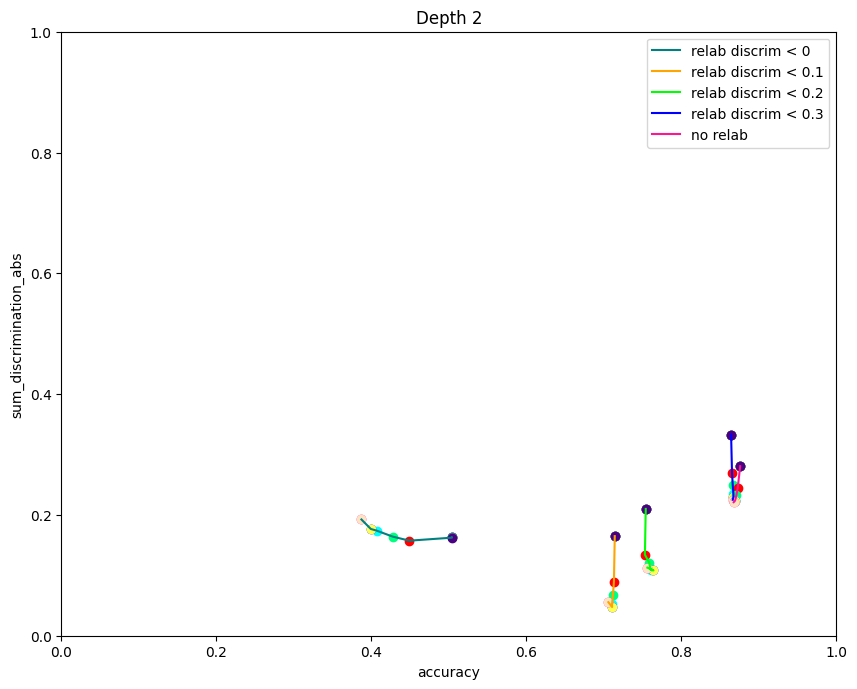

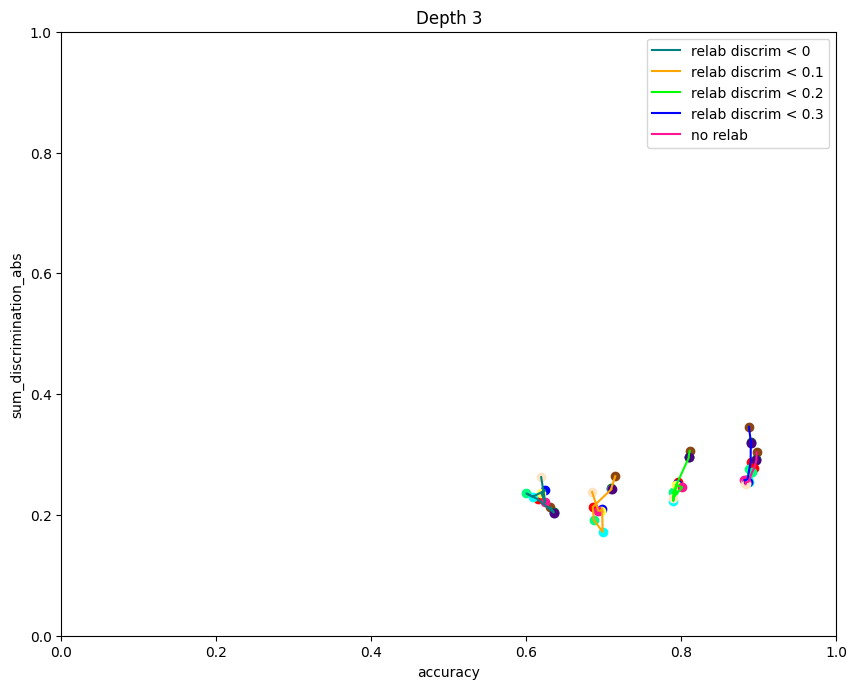

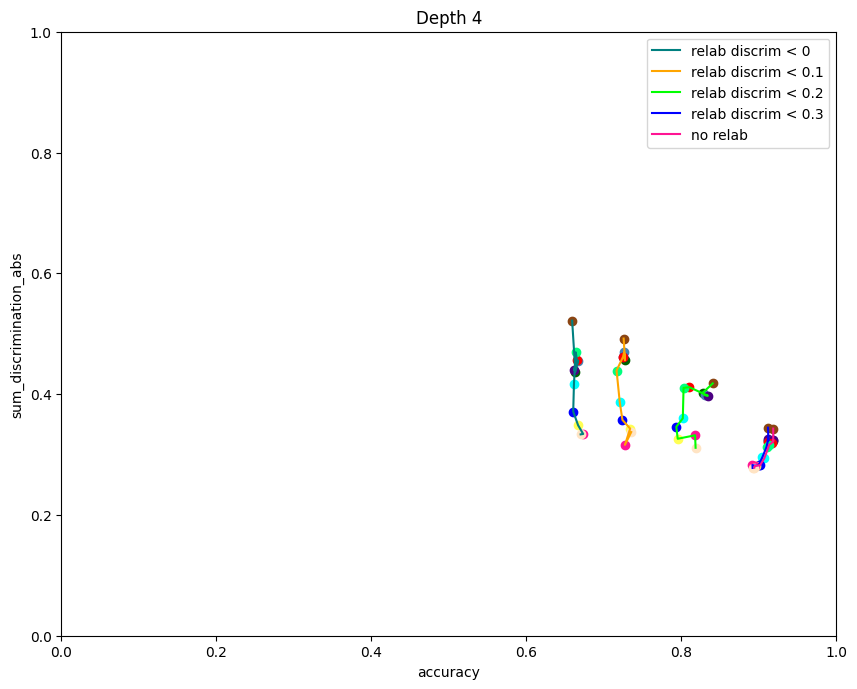

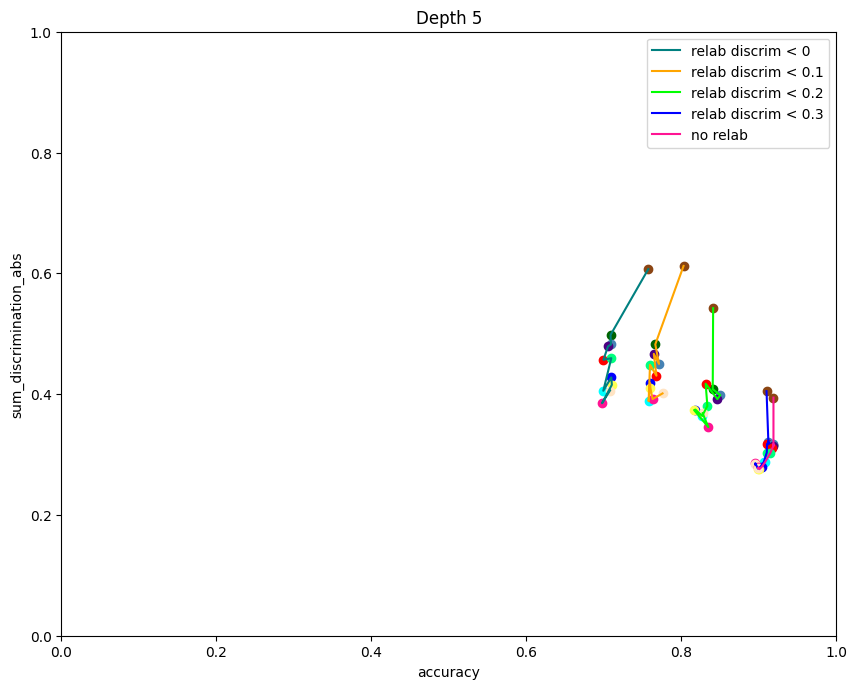

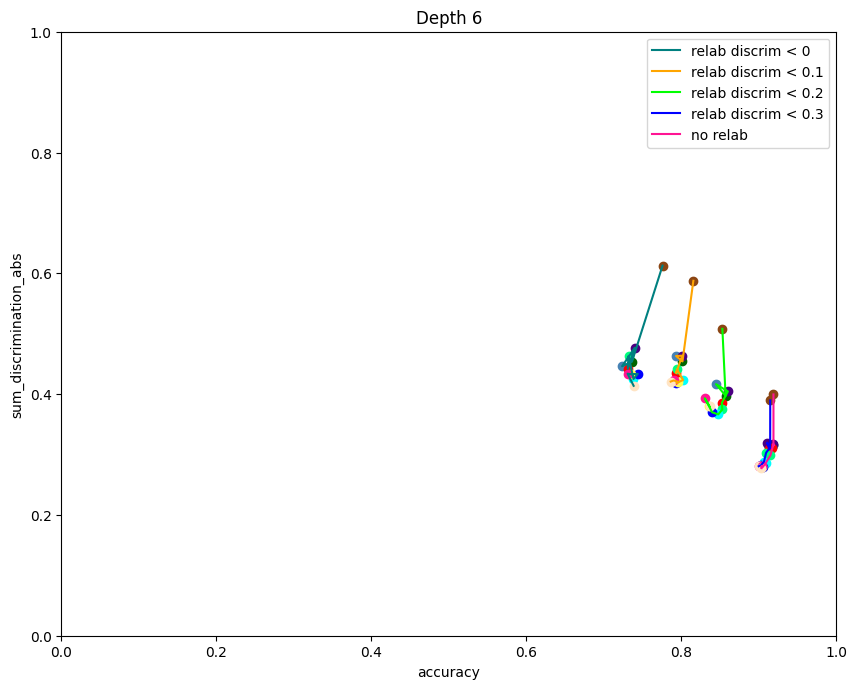

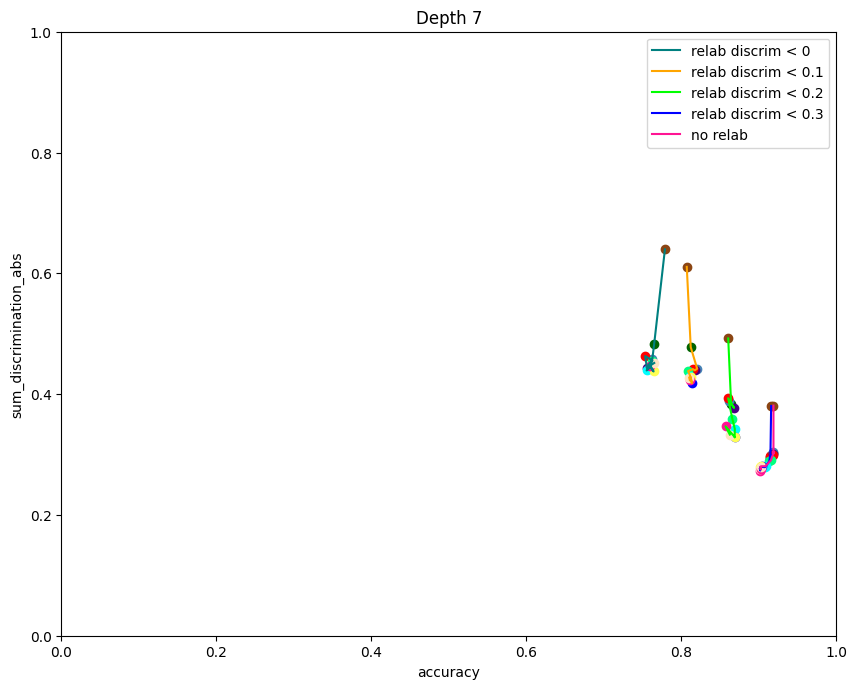

In [13]:
colors11 = _COLORS11.copy()
colors4 = _COLORS5.copy()
legends = ['relab discrim < 0', 'relab discrim < 0.1', 'relab discrim < 0.2', 'relab discrim < 0.3', 'no relab']
fig, axes = plt.subplots()
for depth in df['depth'].unique():
    index_legends = 0
    for x_axe, y_axe in [('accuracy_relab_0.0', 'sum_discri_abs_0.0'), ('accuracy_relab_0.1', 'sum_discri_abs_0.1'), ('accuracy_relab_0.2', 'sum_discri_abs_0.2'), ('accuracy_relab_0.3', 'sum_discri_abs_0.3'), ('accuracy_train', 'sum_discrimination_additive_pred_abs')]:
        index_color = 0
        y_values = list()
        x_values = list()
        for k in df['k'].unique():
            tmp = df.loc[(df["k"] == k) & (df["depth"] == depth)]
            x_values.append(tmp[x_axe].mean())
            y_values.append(tmp[y_axe].mean())

            plt.scatter(tmp[x_axe].mean(), tmp[y_axe].mean(), c=colors11[index_color])
            """
            plt.annotate(k, # this is the text
                         (tmp[x_axe].mean(), tmp[y_axe].mean()), # these are the coordinates to position the label
                         textcoords="offset points", # how to position the text
                         xytext=(0,10), # distance from text to points (x,y)
                         ha='center')
            """
            index_color +=1

        plt.plot(x_values, y_values, label=legends[index_legends], c=colors4[index_legends])
        index_legends +=1
    plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
    plt.title(f'Depth {depth}')
    plt.ylabel('sum_discrimination_abs')
    plt.xlabel('accuracy')
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    plt.legend()

    plt.show()

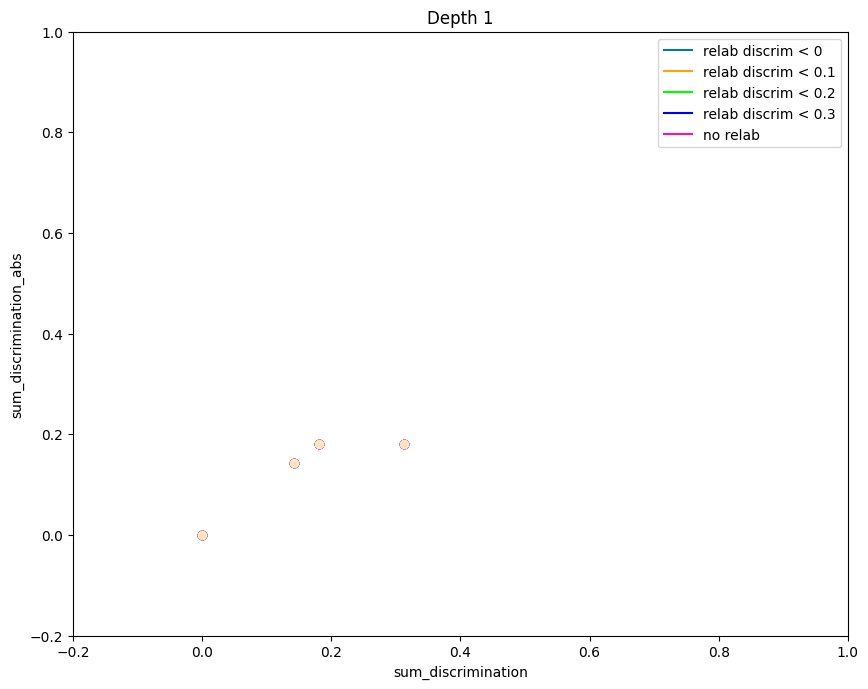

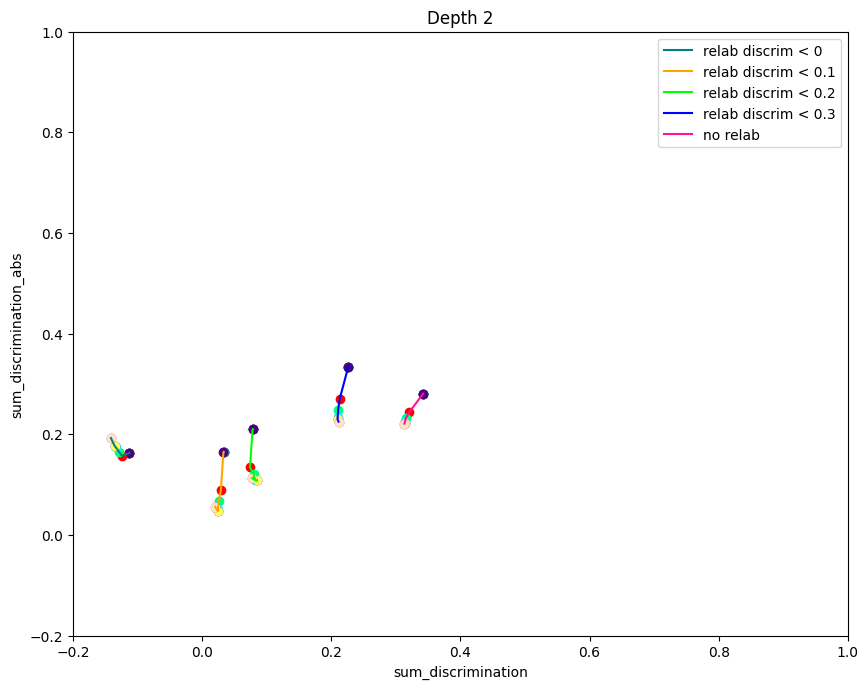

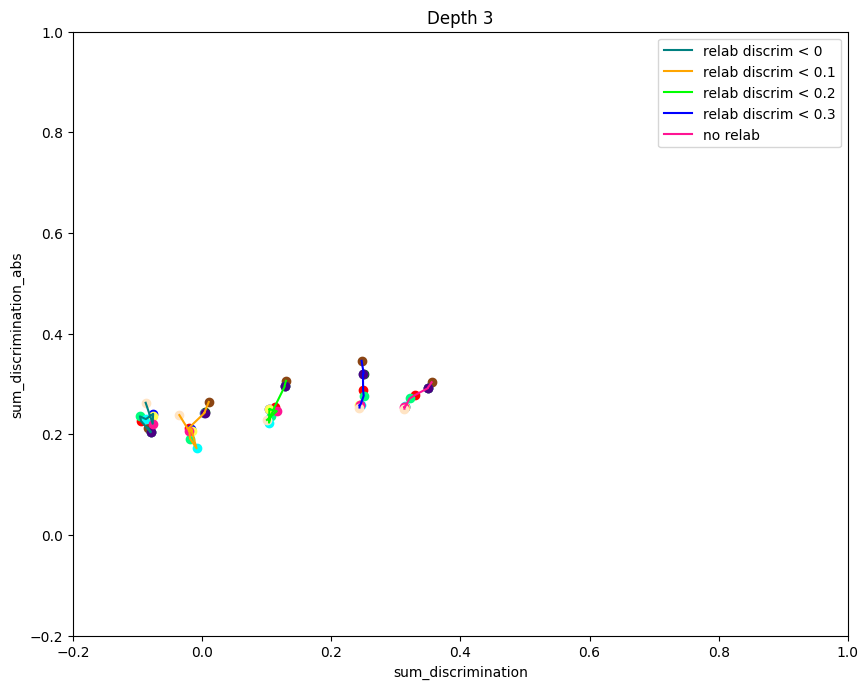

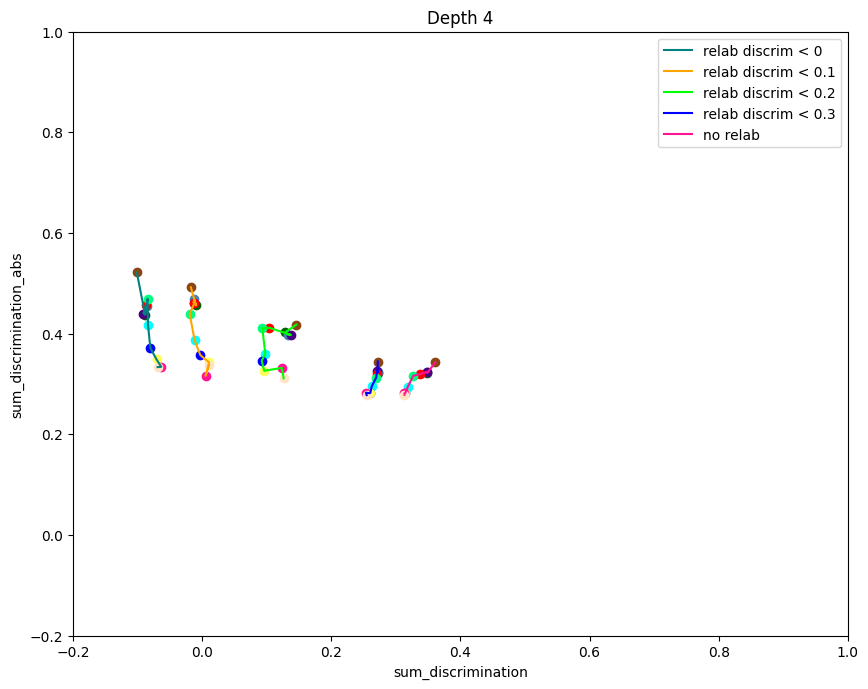

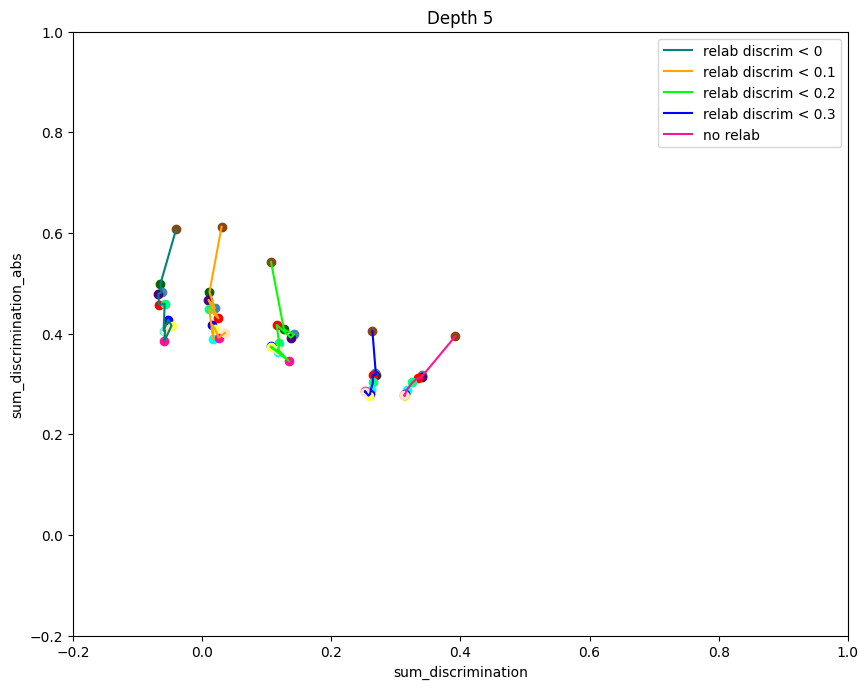

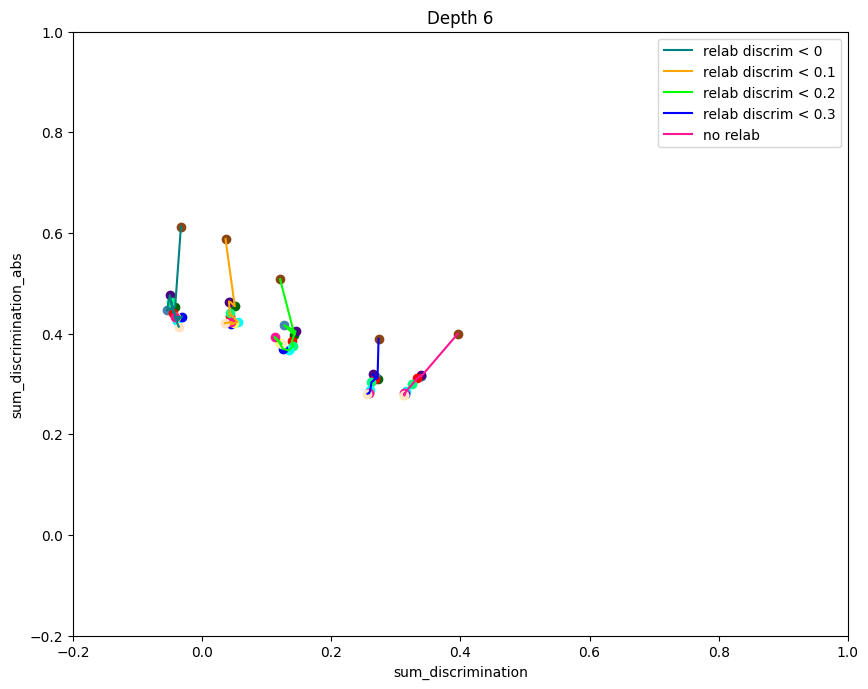

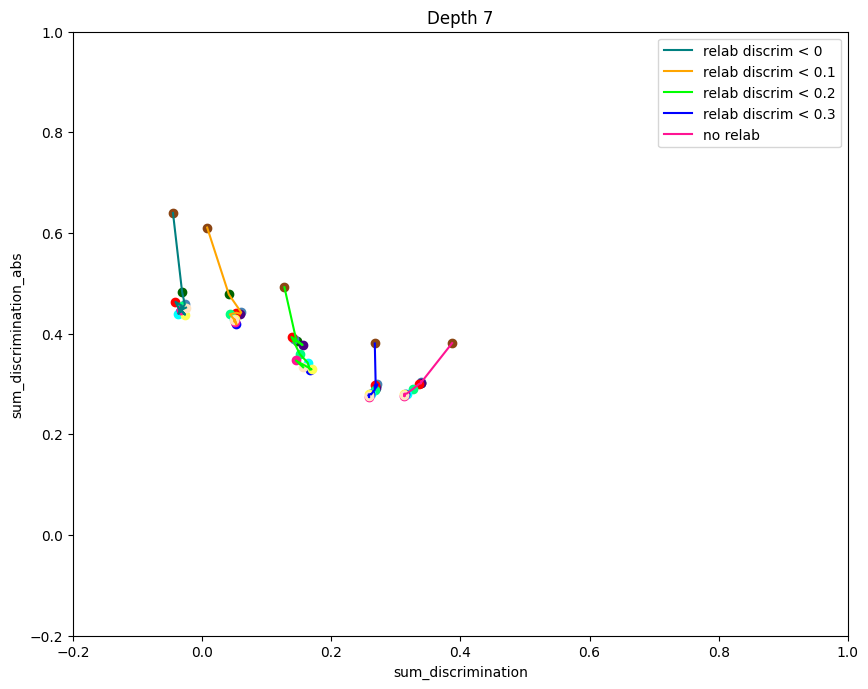

In [14]:
colors11 = _COLORS11.copy()
colors4 = _COLORS5.copy()
legends = ['relab discrim < 0', 'relab discrim < 0.1', 'relab discrim < 0.2', 'relab discrim < 0.3', 'no relab']
fig, axes = plt.subplots()
for depth in df['depth'].unique():
    index_legends = 0
    for x_axe, y_axe in [('sum_discri_0.0', 'sum_discri_abs_0.0'), ('sum_discri_0.1', 'sum_discri_abs_0.1'), ('sum_discri_0.2', 'sum_discri_abs_0.2'), ('sum_discri_0.3', 'sum_discri_abs_0.3'), ('sum_discrimination_additive_train_abs', 'sum_discrimination_additive_pred_abs')]:
        index_color = 0
        y_values = list()
        x_values = list()
        for k in df['k'].unique():
            tmp = df.loc[(df["k"] == k) & (df["depth"] == depth)]
            x_values.append(tmp[x_axe].mean())
            y_values.append(tmp[y_axe].mean())

            plt.scatter(tmp[x_axe].mean(), tmp[y_axe].mean(), c=colors11[index_color])
            """
            plt.annotate(k, # this is the text
                         (tmp[x_axe].mean(), tmp[y_axe].mean()), # these are the coordinates to position the label
                         textcoords="offset points", # how to position the text
                         xytext=(0,10), # distance from text to points (x,y)
                         ha='center')
            """
            index_color +=1

        plt.plot(x_values, y_values, label=legends[index_legends], c=colors4[index_legends])
        index_legends +=1
    plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
    plt.title(f'Depth {depth}')
    plt.ylabel('sum_discrimination_abs')
    plt.xlabel('sum_discrimination')
    plt.ylim(-0.2, 1)
    plt.xlim(-0.2, 1)
    plt.legend()

    plt.show()

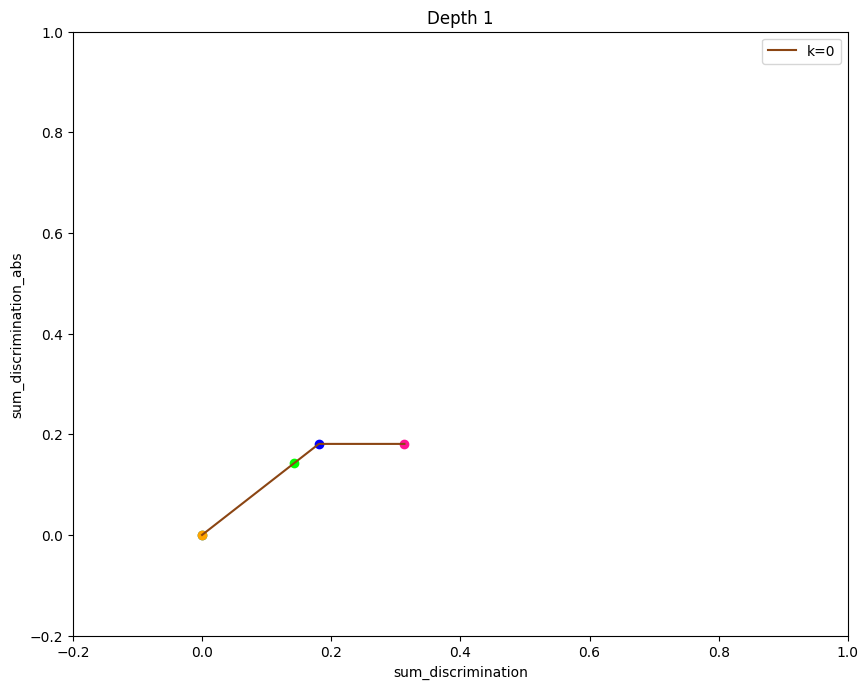

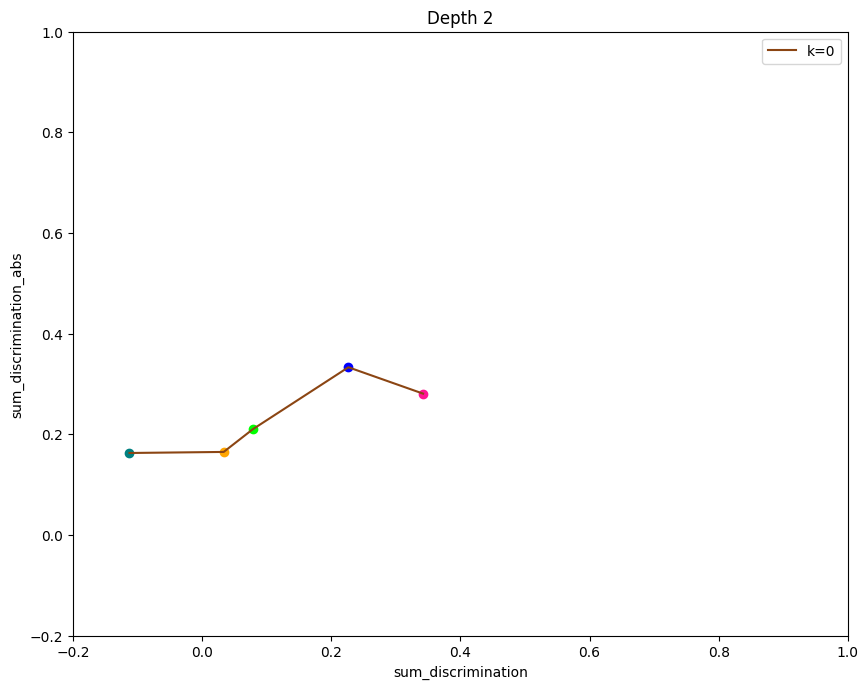

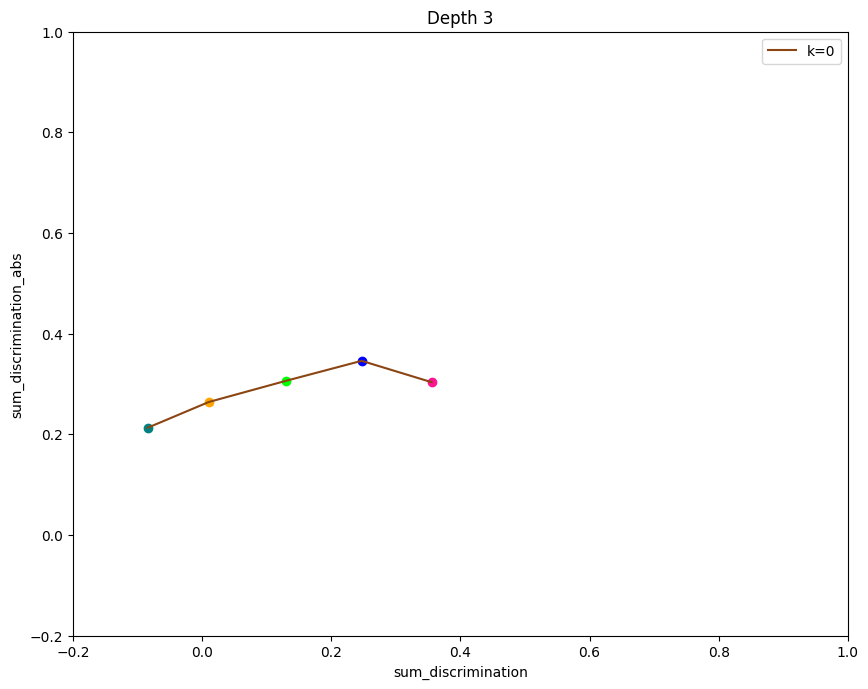

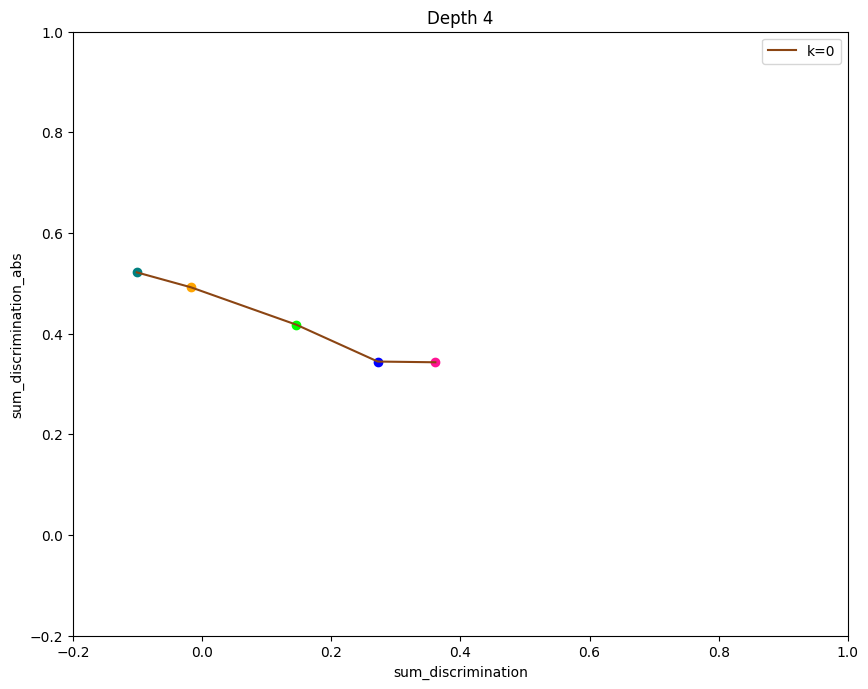

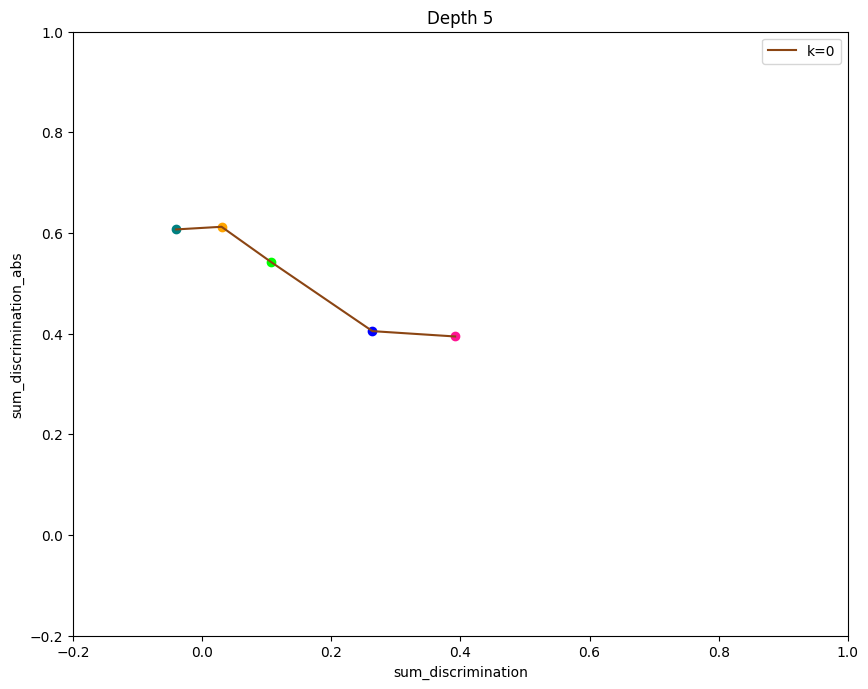

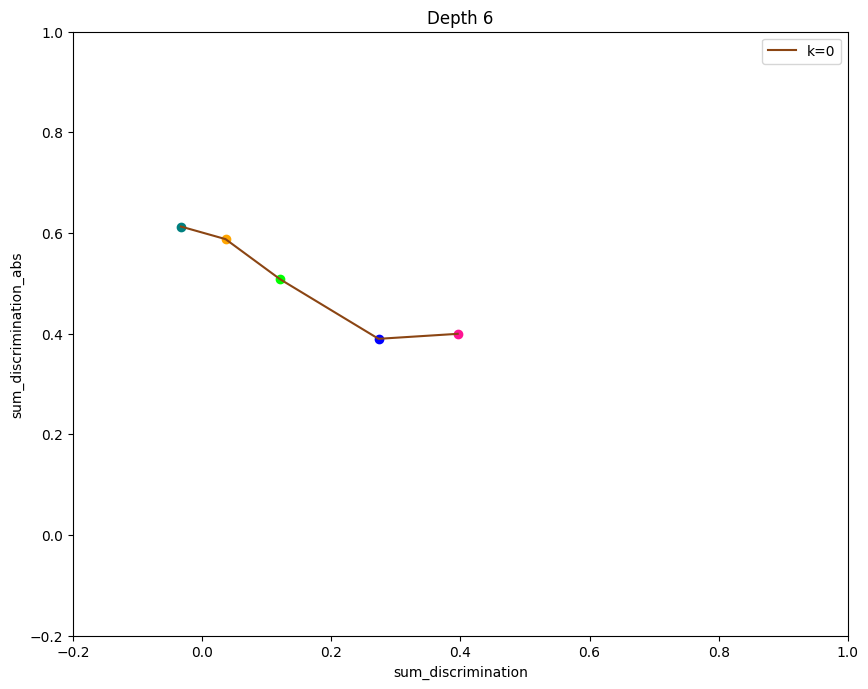

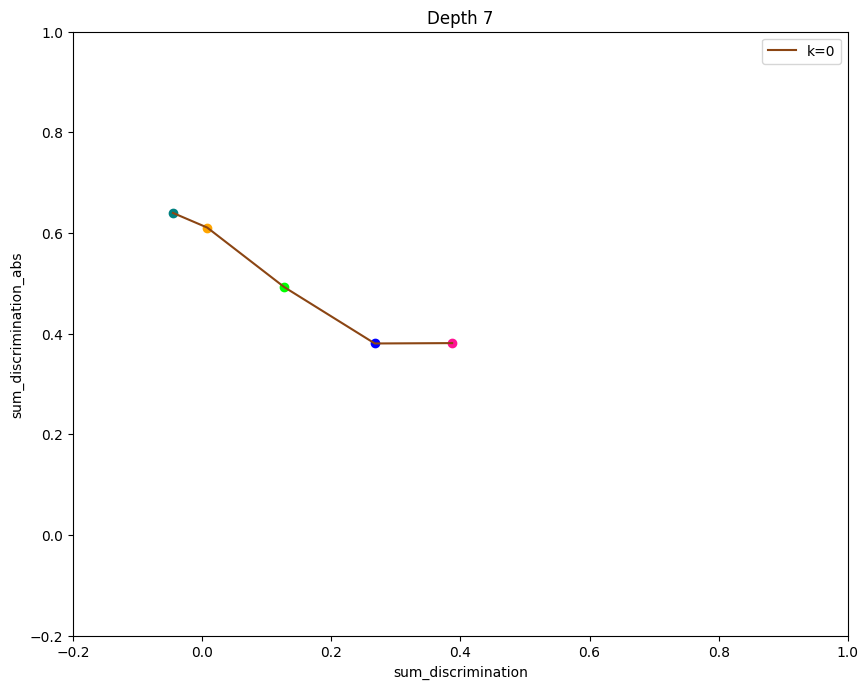

In [15]:
k=0

colors11 = _COLORS11.copy()
colors4 = _COLORS5.copy()
colors7 = _COLORS7.copy()
fig, axes = plt.subplots()
for depth in df['depth'].unique():
    index_legends = 0
   # for k in df['k'].unique():#df['k'].unique():
    #for k in [0, 10, 250, 5000, 100000]:#df['k'].unique():
    index_color = 0
    y_values = list()
    x_values = list()
    for x_axe, y_axe in [('sum_discri_0.0', 'sum_discri_abs_0.0'), ('sum_discri_0.1', 'sum_discri_abs_0.1'), ('sum_discri_0.2', 'sum_discri_abs_0.2'), ('sum_discri_0.3', 'sum_discri_abs_0.3'), ('sum_discrimination_additive_train_abs', 'sum_discrimination_additive_pred_abs')]:



        tmp = df.loc[(df["k"] == k) & (df["depth"] == depth) & (df["k"] == 0)]
        x_values.append(tmp[x_axe].mean())
        y_values.append(tmp[y_axe].mean())

        plt.scatter(tmp[x_axe].mean(), tmp[y_axe].mean(), c=colors4[index_color])
        index_color +=1



    plt.plot(x_values, y_values, label="k="+str(k), c=colors11[index_legends])
    index_legends +=1
    plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
    plt.title(f'Depth {depth}')
    plt.ylabel('sum_discrimination_abs')
    plt.xlabel('sum_discrimination')
    plt.ylim(-0.2, 1)
    plt.xlim(-0.2, 1)
    plt.legend()

    plt.show()